In [4]:
import os
import numpy as np
import pandas as pd
import math

import tensorflow as tf
import keras
from keras import layers, Input, models
from keras.utils import layer_utils, to_categorical, plot_model
from keras.wrappers.scikit_learn import KerasClassifier 
from keras.preprocessing import image
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.utils.vis_utils import model_to_dot
from keras import regularizers, optimizers
from keras.layers import Dropout

from IPython.display import SVG
import matplotlib.pyplot as plt
from scipy import ndimage, misc

from keras import backend as K
K.clear_session()

%matplotlib inline
from matplotlib import gridspec

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.utils.multiclass import unique_labels
import cv2

Using TensorFlow backend.


In [5]:
df=pd.read_pickle("./input/LSWMD.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
waferMap          811457 non-null object
dieSize           811457 non-null float64
lotName           811457 non-null object
waferIndex        811457 non-null float64
trianTestLabel    811457 non-null object
failureType       811457 non-null object
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


In [6]:
df.head()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]


In [7]:
df.tail()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,[[Test]],[[Edge-Ring]]
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,[[Test]],[[Edge-Loc]]
811454,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,25.0,[[Test]],[[Edge-Ring]]
811455,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47543,1.0,[],[]
811456,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47543,2.0,[],[]


# Data Analysis

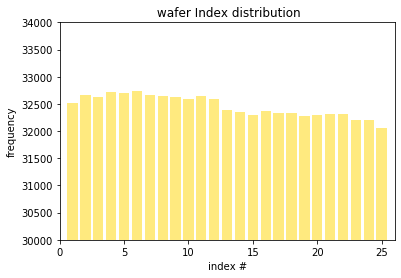

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline


uni_Index=np.unique(df.waferIndex, return_counts=True)
plt.bar(uni_Index[0],uni_Index[1], color='gold', align='center', alpha=0.5)
plt.title(" wafer Index distribution")
plt.xlabel("index #")
plt.ylabel("frequency")
plt.xlim(0,26)
plt.ylim(30000,34000)
plt.show()

In [9]:
df = df.drop(['waferIndex'], axis = 1)

In [10]:
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
df['waferMapDim']=df.waferMap.apply(find_dim)
df.sample(5)

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim
360544,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3274.0,lot21588,[],[],"(60, 69)"
133362,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2007.0,lot8764,[],[],"(42, 61)"
42961,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2,...",515.0,lot3738,[],[],"(25, 27)"
236527,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2300.0,lot14774,[],[],"(55, 53)"
549404,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1513.0,lot34440,[],[],"(49, 39)"


In [11]:
Wdim = np.unique(df['waferMapDim'])

In [12]:
#The dimension of wafer map, or saying the image size are not always the same. There are 632 different size for wafer map
Wdim.size

632

In [13]:
#max dimension : 300 x 202, min dim: 6 x 21
#we need to do data tranformation (feature extraction) to make input the same dim.
max(df.waferMapDim), min(df.waferMapDim)

((300, 202), (6, 21))

In [14]:
tol_wafers = df.shape[0]
tol_wafers

811457

In [15]:
df['failureNum']=df.failureType
df['trainTestNum']=df.trianTestLabel
mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
mapping_traintest={'Training':0,'Test':1}
df=df.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})

C:\Users\jsamo\Anaconda3\lib\site-packages\pandas\core\internals\managers.py:1937: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  op = lambda x: operator.eq(x, b)


In [16]:
df_withlabel = df[(df['failureNum']>=0) & (df['failureNum']<=8)]
df_withlabel =df_withlabel.reset_index()
df_withpattern = df[(df['failureNum']>=0) & (df['failureNum']<=7)]
df_withpattern = df_withpattern.reset_index()
df_nonpattern = df[(df['failureNum']==8)]
df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]

(172950, 25519, 147431)

In [17]:
# imbalanced dataset

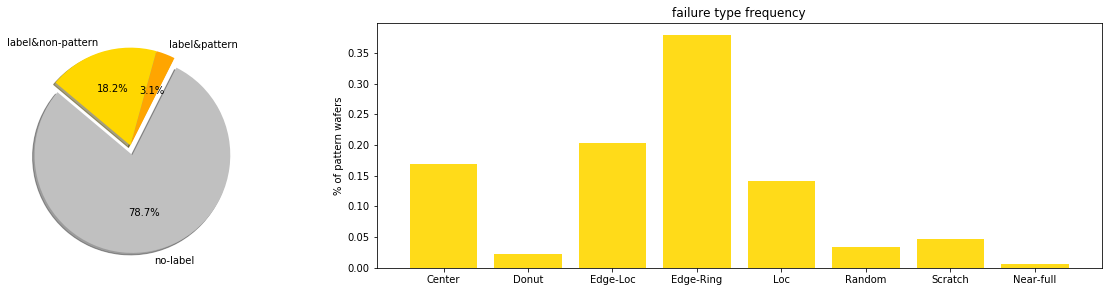

In [18]:
#In summary, 172,950 wafers have labels while 78.7% wafers with no label based on failureType variable filtering.
#Among labeled wafer, only 3.1% wafers (25,519 wafers) have real failure patterns while 147,431 wafers were still labeled none. As a result, we only focus on thoes 25,519 instances which heavily reduce the calculated amount for our work.
#From the second picture shown above, the dataset shows high imbalance distribution.

fig = plt.figure(figsize=(20, 4.5)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2.5]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

no_wafers=[tol_wafers-df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]]

colors = ['silver', 'orange', 'gold']
explode = (0.1, 0, 0)  # explode 1st slice
labels = ['no-label','label&pattern','label&non-pattern']
ax1.pie(no_wafers, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)

uni_pattern=np.unique(df_withpattern.failureNum, return_counts=True)
labels2 = ['','Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']
ax2.bar(uni_pattern[0],uni_pattern[1]/df_withpattern.shape[0], color='gold', align='center', alpha=0.9)
ax2.set_title("failure type frequency")
ax2.set_ylabel("% of pattern wafers")
ax2.set_xticklabels(labels2)

plt.show()

In [19]:
# imbalanced dataset for dimension too!

In [20]:
#cnt = np.zeros(Wdim.size)
#c_maxdim = 0

#for i in range(Wdim.size):
#    sdf = df.loc[df['waferMapDim'] == Wdim[i]]
#    cnt[i] = 0

#    for j in range(len(sdf)):
    # skip null label
#        if len(sdf.iloc[j,:]['failureType']) == 0:
#            continue
#        cnt[i] += 1

#print(c_maxdim)
#print(Wdim[c_index])
#for i in range(cnt.size):
#    if Wdim[i][(0)] > 24:
#        print('shape: {}, #: {}'.format(Wdim[i], cnt[i]))

In [21]:
sub_df = df.loc[df['waferMapDim'] == (25, 27)]
sub_wafer = sub_df['waferMap'].values

sw = np.ones((1, 25, 27))
label = list()

for i in range(len(sub_df)):
    # skip null label
    if len(sub_df.iloc[i,:]['failureType']) == 0:
        continue
    sw = np.concatenate((sw, sub_df.iloc[i,:]['waferMap'].reshape(1, 25, 27)))
    label.append(sub_df.iloc[i,:]['failureType'][0][0])

In [22]:
x1 = sw[1:]
x = np.pad(x1, ((0,0),(1,1),(0,0)), mode='constant', constant_values = (0,0))
y = np.array(label).reshape((-1,1))

In [23]:
# check dimension
print('x shape : {}, y shape : {}'.format(x.shape, y.shape))

x shape : (18781, 27, 27), y shape : (18781, 1)


In [24]:
sub_df1 = df.loc[df['waferMapDim'] == (26, 26)]
sub_wafer1 = sub_df1['waferMap'].values

sw1 = np.ones((1, 26, 26))
label1 = list()

for i in range(len(sub_df1)):
    # skip null label
    if len(sub_df1.iloc[i,:]['failureType']) == 0:
        continue
    sw1 = np.concatenate((sw1, sub_df1.iloc[i,:]['waferMap'].reshape(1, 26, 26)))
    label1.append(sub_df1.iloc[i,:]['failureType'][0][0])

In [25]:
x2 = sw1[1:]
x3 = np.pad(x2, ((0,0),(1,0),(1,0)), mode='constant', constant_values = (0,0))
y2 = np.array(label1).reshape((-1,1))

In [26]:
print('x3 shape : {}, y2 shape : {}'.format(x3.shape, y2.shape))

x3 shape : (14366, 27, 27), y2 shape : (14366, 1)


In [27]:
sub_df2 = df.loc[df['waferMapDim'] == (27, 25)]
sub_wafer2 = sub_df2['waferMap'].values

sw2 = np.ones((1, 27, 25))
label2= list()

for i in range(len(sub_df2)):
    # skip null label
    if len(sub_df2.iloc[i,:]['failureType']) == 0:
        continue
    sw2 = np.concatenate((sw2, sub_df2.iloc[i,:]['waferMap'].reshape(1, 27, 25)))
    label2.append(sub_df2.iloc[i,:]['failureType'][0][0])

In [28]:
x4 = sw2[1:]
x5 = np.pad(x4, ((0,0),(0,0),(1,1)), mode='constant', constant_values = (0,0))
y3 = np.array(label2).reshape((-1,1))

In [29]:
print('x5 shape : {}, y3 shape : {}'.format(x5.shape, y3.shape))

x5 shape : (10682, 27, 27), y3 shape : (10682, 1)


In [30]:
x3 = np.concatenate((x3, x5[0:]))
y2 = np.concatenate((y2, y3))

In [31]:
x = np.concatenate((x, x3[0:]))
y = np.concatenate((y, y2))

In [32]:
print('x shape : {}, y shape : {}'.format(x.shape, y.shape))

x shape : (43829, 27, 27), y shape : (43829, 1)


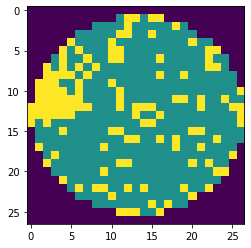

Faulty case : ['Edge-Loc'] 


In [33]:
# plot 1st data
plt.imshow(x[0])
plt.show()

# check faulty case
print('Faulty case : {} '.format(y[0]))

In [34]:
faulty_case = np.unique(y)
print('Faulty case list : {}'.format(faulty_case))

Faulty case list : ['Center' 'Donut' 'Edge-Loc' 'Edge-Ring' 'Loc' 'Near-full' 'Random'
 'Scratch' 'none']


In [35]:
for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))

Center : 2364
Donut : 7
Edge-Loc : 747
Edge-Ring : 56
Loc : 573
Near-full : 48
Random : 137
Scratch : 102
none : 39795


In [36]:
Scratch_idx = np.where(y=='Scratch')[0][0]

In [37]:
rot_e30 = ndimage.rotate(x[Scratch_idx], 30, axes=(0,1), mode='constant', order = 0, reshape=False)

In [38]:
rot_e45 = ndimage.rotate(x[Scratch_idx], 45, axes=(0,1), mode='constant', order = 0, reshape=False)

In [39]:
rot_e90 = ndimage.rotate(x[Scratch_idx], 90, axes=(0,1), mode='constant', order = 0, reshape=False)

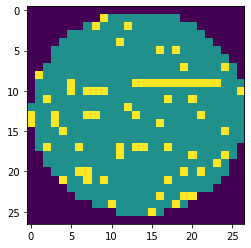

Faulty case : ['Scratch'] 


In [40]:
# plot Donut fault data
plt.imshow(x[Scratch_idx])
plt.show()

# check faulty case
print('Faulty case : {} '.format(y[Scratch_idx]))

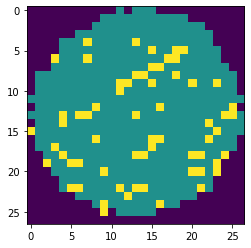

In [41]:
# plot 30 degree rotated Donut fault data
plt.imshow(rot_e30)
plt.show()

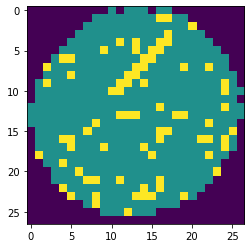

In [42]:
#plot 45 degree rotated Donut fault data
plt.imshow(rot_e45)
plt.show()

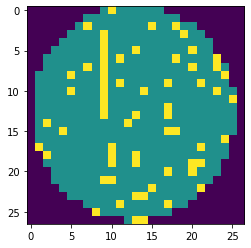

In [43]:
# plot 90 degree rotated Donut fault data
plt.imshow(rot_e90)
plt.show()

In [44]:
# choice index with y='none'(no defect) and delete choiced index data.
none_idx = np.where(y=='none')[0][np.random.choice(len(np.where(y=='none')[0]), size=25000, replace=False)]
new_x = np.delete(x, none_idx, axis=0)
new_y = np.delete(y, none_idx, axis=0)

In [45]:
print('After Delete "none" class new_x shape : {}, new_y shape : {}'.format(new_x.shape, new_y.shape))

After Delete "none" class new_x shape : (18829, 27, 27), new_y shape : (18829, 1)


In [46]:
for f in faulty_case :
    print('{} : {}'.format(f, len(new_y[new_y==f])))

Center : 2364
Donut : 7
Edge-Loc : 747
Edge-Ring : 56
Loc : 573
Near-full : 48
Random : 137
Scratch : 102
none : 14795


In [51]:
#Before Data augmentation: Split the data with 8:2 ratio
x_train_temp, x_test, y_train_temp, y_test = train_test_split(new_x, new_y, test_size=0.2, random_state=789)

In [52]:
print('Train x : {}, y : {}'.format(x_train_temp.shape, y_train_temp.shape))
print('Test x: {}, y : {}'.format(x_test.shape, y_test.shape))

Train x : (15063, 27, 27), y : (15063, 1)
Test x: (3766, 27, 27), y : (3766, 1)


In [53]:
#Before data augmentation : Train Data Distribution
for f in faulty_case :
    print('{} : {}'.format(f, len(y_train_temp[y_train_temp==f])))

Center : 1892
Donut : 6
Edge-Loc : 596
Edge-Ring : 49
Loc : 441
Near-full : 39
Random : 103
Scratch : 81
none : 11856


In [54]:
#Test Data Distribution
for f in faulty_case :
    print('{} : {}'.format(f, len(y_test[y_test==f])))

Center : 472
Donut : 1
Edge-Loc : 151
Edge-Ring : 7
Loc : 132
Near-full : 9
Random : 34
Scratch : 21
none : 2939


In [55]:
#x_test : add channel
x_test = x_test.reshape((-1, 27, 27, 1))

In [56]:
#Wafer data's each pixels have a categorical variable that express 0 : not wafer, 1 : normal, 2 : faulty.
#Extend extra dimension with one-hot-encoded categorical data as channel.
#that idea from Data Science & Business Analytics Lab, School of Industrial Management Engineering, College of Engineering, Korea University[http://dsba.korea.ac.kr/main]

In [57]:
# One-hot-Encoding faulty categorical variable as channel
nx_test = np.zeros((len(x_test), 27, 27, 3))

for w in range(len(x_test)):
    for i in range(27):
        for j in range(27):
            nx_test[w, i, j, int(x_test[w, i, j])] = 1

In [58]:
nx_test.shape

(3766, 27, 27, 3)

In [59]:
#y_test : make string label data to numerical data
for i, l in enumerate(faulty_case):
    y_test[y_test==l] = i
    
# one-hot-encoding
y_test = to_categorical(y_test)

In [60]:
x_train_temp.shape

(15063, 27, 27)

In [61]:
# One-hot-Encoding faulty categorical variable as channel
nx_train = np.zeros((len(x_train_temp), 27, 27, 3))

for w in range(len(x_train_temp)):
    for i in range(27):
        for j in range(27):
            nx_train[w, i, j, int(x_train_temp[w, i, j])] = 1

In [62]:
nx_train.shape

(15063, 27, 27, 3)


# Convolutional Autoencoder for augmentation.


In [63]:
sx_train = np.delete(nx_train,(0,0,0,0), 1)

In [64]:
nx_train.shape, sx_train.shape

((15063, 27, 27, 3), (15063, 26, 27, 3))

In [65]:
sx_train = np.delete(sx_train,(0,0,0,0), 2)

In [66]:
nx_train.shape, sx_train.shape

((15063, 27, 27, 3), (15063, 26, 26, 3))

In [67]:
epoch = 50
batch_size=500

In [68]:
# Encoder
input_shape = (26, 26, 3)
input_tensor = Input(input_shape)
encode = layers.Conv2D(64, (3,3), padding='same', activation='relu')(input_tensor)

latent_vector = layers.MaxPool2D(padding='same')(encode)

# Decoder
decode_layer_1 = layers.Conv2DTranspose(64, (3,3), padding='same', activation='relu')
decode_layer_2 = layers.UpSampling2D()
output_tensor = layers.Conv2DTranspose(3, (3,3), padding='same', activation='sigmoid')

# connect decoder layers
decode = decode_layer_1(latent_vector)
decode = decode_layer_2(decode)

AEncoder = models.Model(input_tensor, output_tensor(decode))
AEncoder.compile(optimizer = 'Adam',
              loss = 'mse',
             )

In [69]:
AEncoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 26, 26, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 64)        1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 13, 13, 64)        36928     
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 26, 26, 3)         1731      
Total params: 40,451
Trainable params: 40,451
Non-trainable params: 0
_______________________________________________________

In [70]:
# start train
AEncoder.fit(sx_train, sx_train, batch_size=batch_size, epochs=epoch, verbose=2)


Epoch 1/50
 - 4s - loss: 0.1346
Epoch 2/50
 - 2s - loss: 0.0764
Epoch 3/50
 - 2s - loss: 0.0599
Epoch 4/50
 - 2s - loss: 0.0502
Epoch 5/50
 - 2s - loss: 0.0419
Epoch 6/50
 - 2s - loss: 0.0347
Epoch 7/50
 - 2s - loss: 0.0291
Epoch 8/50
 - 2s - loss: 0.0249
Epoch 9/50
 - 2s - loss: 0.0218
Epoch 10/50
 - 2s - loss: 0.0194
Epoch 11/50
 - 2s - loss: 0.0175
Epoch 12/50
 - 2s - loss: 0.0159
Epoch 13/50
 - 2s - loss: 0.0146
Epoch 14/50
 - 2s - loss: 0.0134
Epoch 15/50
 - 2s - loss: 0.0124
Epoch 16/50
 - 2s - loss: 0.0115
Epoch 17/50
 - 2s - loss: 0.0107
Epoch 18/50
 - 2s - loss: 0.0100
Epoch 19/50
 - 2s - loss: 0.0093
Epoch 20/50
 - 2s - loss: 0.0087
Epoch 21/50
 - 2s - loss: 0.0082
Epoch 22/50
 - 2s - loss: 0.0078
Epoch 23/50
 - 2s - loss: 0.0073
Epoch 24/50
 - 2s - loss: 0.0070
Epoch 25/50
 - 2s - loss: 0.0066
Epoch 26/50
 - 2s - loss: 0.0063
Epoch 27/50
 - 2s - loss: 0.0061
Epoch 28/50
 - 2s - loss: 0.0058
Epoch 29/50
 - 2s - loss: 0.0056
Epoch 30/50
 - 2s - loss: 0.0054
Epoch 31/50
 - 2s 

In [71]:
# Make encoder model with part of autoencoder model layers
encoder = models.Model(input_tensor, latent_vector)

In [72]:
# Make decoder model with part of autoencoder model layers
decoder_input = Input((13, 13, 64))
decode = decode_layer_1(decoder_input)
decode = decode_layer_2(decode)

decoder = models.Model(decoder_input, output_tensor(decode))

In [73]:
# Encode original faulty wafer
encoded_x = encoder.predict(sx_train)

In [74]:
# Add noise to encoded latent faulty wafers vector.
noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64))

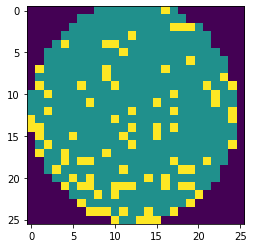

In [75]:
# check original faulty wafer data
plt.imshow(np.argmax(sx_train[3], axis=2))

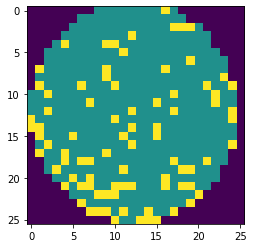

In [76]:
# check new noised faulty wafer data
noised_gen_x = np.argmax(decoder.predict(noised_encoded_x), axis=3)
plt.imshow(noised_gen_x[3])

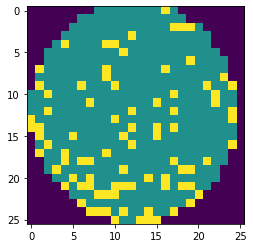

In [77]:
# check reconstructed original faulty wafer data
gen_x = np.argmax(AEncoder.predict(sx_train), axis=3)
plt.imshow(gen_x[3])

In [78]:
gen_x.shape

(15063, 26, 26)

In [79]:
y_train_temp.shape

(15063, 1)

In [80]:
sy_train_temp = np.array(y_train_temp)

In [81]:
# augment function define
def gen_data(wafer, label):
    # Encode input wafer
    encoded_x = encoder.predict(wafer)
    
    # dummy array for collecting noised wafer
    genn_x = np.zeros((1, 26, 26, 3))
    
    # Make wafer until total # of wafer to 10000
    for i in range((10000//len(wafer)) + 1):
        noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64)) 
        noised_gen_x = decoder.predict(noised_encoded_x)
        genn_x = np.concatenate((genn_x, noised_gen_x), axis=0)
    # also make label vector with same length
    gen_y = np.full((len(genn_x), 1), label)
    
    # return date without 1st dummy data.
    return genn_x[1:], gen_y[1:]

In [82]:
# Augmentation for all faulty case.
for f in faulty_case : 
    # skip none case
    if f == 'none' : 
        continue
    genn_x, genn_y = gen_data(sx_train[np.where(y_train_temp==f)[0]], f)
    sx_train = np.concatenate((sx_train, genn_x), axis=0)
    sy_train_temp = np.concatenate((sy_train_temp, genn_y))

In [83]:
sx_train.shape, sy_train_temp.shape

((96898, 26, 26, 3), (96898, 1))

In [84]:
#new training dataset
for i, f in enumerate(faulty_case) :
    print('{} : {}'.format(f, len(sy_train_temp[sy_train_temp==f])))

Center : 13244
Donut : 10008
Edge-Loc : 10728
Edge-Ring : 10094
Loc : 10584
Near-full : 10062
Random : 10197
Scratch : 10125
none : 11856


In [85]:
nsx_train = np.pad(sx_train, ((0,0),(1,0),(1,0),(0,0)), mode='constant', constant_values = (0,0))

In [86]:
nsx_train.shape

(96898, 27, 27, 3)

In [87]:
#y_test : make string label data to numerical data
for i, l in enumerate(faulty_case):
    sy_train_temp[sy_train_temp==l] = i
    
# one-hot-encoding
y_train = to_categorical(sy_train_temp)

In [88]:
y_train.shape

(96898, 9)

# Simplified VGG-16 Model #

In [299]:
def create_model():
    input_shape = (27, 27, 3)
    input_tensor = Input(input_shape)
    
    #initializer: glorot_normal, glorot_uniform, he_normal, he_uniform

    conv_1 = layers.Conv2D(32, (3,3), kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l2(0.001), activation='relu',padding='same')(input_tensor)
    conv_2 = layers.Conv2D(64, (3,3), kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l2(0.001), activation='relu',padding='same')(conv_1)
    pool_1 = layers.MaxPool2D((2,2), name = 'max_pool1')(conv_2)

    conv_3 = layers.Conv2D(128, (3,3), kernel_initializer='glorot_uniform',activation='relu', kernel_regularizer=regularizers.l2(0.001), padding='same')(pool_1)
    conv_4 = layers.Conv2D(256, (3,3), kernel_initializer='glorot_uniform',activation='relu', kernel_regularizer=regularizers.l2(0.001), padding='same')(conv_3)
    pool_2 = layers.MaxPool2D((2,2), name = 'max_pool2')(conv_4)

    flat = layers.Flatten()(pool_2)

    dense_1 = layers.Dense(512, activation='relu')(flat)
    drop_1 = layers.Dropout(0.4)(dense_1)
    dense_2 = layers.Dense(256, activation='relu')(drop_1)
    output_tensor = layers.Dense(9, activation='softmax')(dense_2)

    model = models.Model(input_tensor, output_tensor)
 
    return model

In [300]:
W0_model = create_model()

In [301]:
W0_model.compile(optimizer= optimizers.Adam(learning_rate = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [302]:
W0_model.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 27, 27, 3)         0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 27, 27, 32)        896       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 27, 27, 64)        18496     
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 13, 13, 128)       73856     
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 13, 13, 256)       295168    
_________________________________________________________________
max_pool2 (MaxPooling2D)     (None, 6, 6, 256)         0   

In [303]:
Hist0 = W0_model.fit(nsx_train, y_train, epochs=50, validation_data=[nx_test, y_test], batch_size=900, shuffle=True)

Train on 97043 samples, validate on 3766 samples
Epoch 1/50
97043/97043 [==============================] - 20s 207us/step - loss: 0.7939 - accuracy: 0.7724 - val_loss: 0.3875 - val_accuracy: 0.9334
Epoch 2/50
97043/97043 [==============================] - 14s 148us/step - loss: 0.2414 - accuracy: 0.9705 - val_loss: 0.2726 - val_accuracy: 0.9634
Epoch 3/50
97043/97043 [==============================] - 14s 148us/step - loss: 0.1650 - accuracy: 0.9865 - val_loss: 0.3285 - val_accuracy: 0.9270
Epoch 4/50
97043/97043 [==============================] - 14s 149us/step - loss: 0.1388 - accuracy: 0.9899 - val_loss: 0.2237 - val_accuracy: 0.9655
Epoch 5/50
97043/97043 [==============================] - 14s 149us/step - loss: 0.1021 - accuracy: 0.9951 - val_loss: 0.2096 - val_accuracy: 0.9689
Epoch 6/50
97043/97043 [==============================] - 15s 150us/step - loss: 0.1235 - accuracy: 0.9850 - val_loss: 0.2247 - val_accuracy: 0.9607
Epoch 7/50
97043/97043 [==============================] -

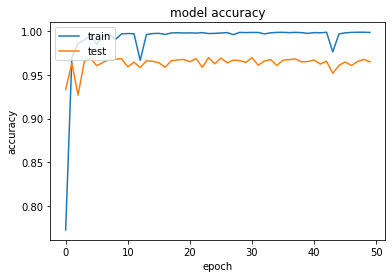

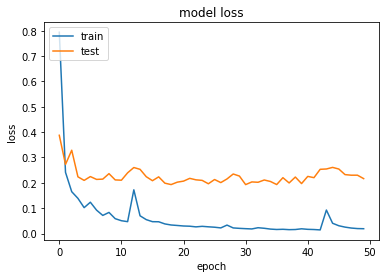

In [304]:
# accuracy plot 
plt.plot(Hist0.history['accuracy'])
plt.plot(Hist0.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(Hist0.history['loss'])
plt.plot(Hist0.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [305]:
y0_pred = W0_model.predict(nx_test)

In [306]:
y0_test_decode = np.ones(len(y_test))
y0_pred_decode = np.ones(len(y0_pred))

for i in range(len(y0_pred)):
    y0_pred_decode[i] = np.argmax(y0_pred[i])
    y0_test_decode[i] = np.argmax(y_test[i])

In [307]:
mis_index0 = np.where(y0_pred_decode != y0_test_decode)

In [308]:
print(classification_report(y0_test_decode, y0_pred_decode, target_names=faulty_case))

              precision    recall  f1-score   support

      Center       0.98      0.99      0.98       442
       Donut       1.00      1.00      1.00         1
    Edge-Loc       0.85      0.80      0.82       158
   Edge-Ring       0.83      0.83      0.83         6
         Loc       0.72      0.72      0.72       109
   Near-full       0.65      1.00      0.79        11
      Random       0.81      0.74      0.78        35
     Scratch       0.75      0.33      0.46        27
        none       0.98      0.99      0.99      2977

    accuracy                           0.97      3766
   macro avg       0.84      0.82      0.82      3766
weighted avg       0.96      0.97      0.96      3766



In [89]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[ 437    0    0    0    1    0    0    0    4]
 [   0    1    0    0    0    0    0    0    0]
 [   1    0  126    1    5    3    3    0   19]
 [   0    0    1    5    0    0    0    0    0]
 [   4    0    6    0   78    0    3    1   17]
 [   0    0    0    0    0   11    0    0    0]
 [   0    0    4    0    1    3   26    0    1]
 [   1    0    1    0    5    0    0    9   11]
 [   4    0   10    0   19    0    0    2 2942]]
Normalized confusion matrix
[[9.89e-01 0.00e+00 0.00e+00 0.00e+00 2.26e-03 0.00e+00 0.00e+00 0.00e+00
  9.05e-03]
 [0.00e+00 1.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  0.00e+00]
 [6.33e-03 0.00e+00 7.97e-01 6.33e-03 3.16e-02 1.90e-02 1.90e-02 0.00e+00
  1.20e-01]
 [0.00e+00 0.00e+00 1.67e-01 8.33e-01 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  0.00e+00]
 [3.67e-02 0.00e+00 5.50e-02 0.00e+00 7.16e-01 0.00e+00 2.75e-02 9.17e-03
  1.56e-01]
 [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00

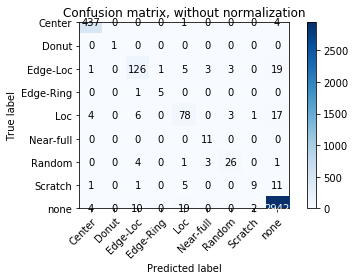

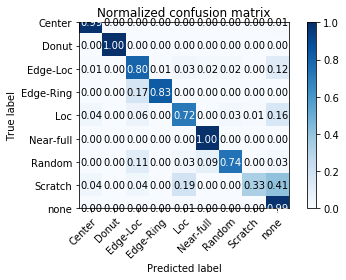

In [309]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y0_test_decode, y0_pred_decode, classes=faulty_case, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y0_test_decode, y0_pred_decode, classes=faulty_case, normalize=True, title='Normalized confusion matrix')

plt.show()

# GAP(Global Average Pooling) added model for Class Activation Map(CAM)

In [310]:
def GAP_create_model():
    input_shape = (27, 27, 3)
    input_tensor = Input(input_shape)
    
    #initializer: glorot_normal, glorot_uniform, he_normal, he_uniform

    conv_1 = layers.Conv2D(32, (3,3), kernel_initializer='he_normal', activation='relu',padding='same')(input_tensor)
    conv_2 = layers.Conv2D(64, (3,3), kernel_initializer='he_normal', activation='relu',padding='same')(conv_1)

    pool_1 = layers.MaxPool2D((2,2), name = 'max_pool1')(conv_2)

    conv_3 = layers.Conv2D(128, (3,3), kernel_initializer='he_normal',activation='relu', padding='same')(pool_1)
    conv_4 = layers.Conv2D(256, (3,3), kernel_initializer='he_normal',activation='relu', padding='same')(conv_3)

    pool_2 = layers.GlobalAveragePooling2D()(conv_4) #GAP layer

    dense_1 = layers.Dense(512, activation='relu')(pool_2)
    drop_1 = layers.Dropout(0.1)(dense_1)
    dense_2 = layers.Dense(256, activation='relu')(drop_1)
    output_tensor = layers.Dense(9, activation='softmax')(dense_2)

    model = models.Model(input_tensor, output_tensor)
 
    return model

In [311]:
W_model = GAP_create_model()

In [312]:
W_model.compile(optimizer= optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [313]:
W_model.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        (None, 27, 27, 3)         0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 27, 27, 32)        896       
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 27, 27, 64)        18496     
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 13, 13, 128)       73856     
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 13, 13, 256)       295168    
_________________________________________________________________
global_average_pooling2d_2 ( (None, 256)               0  

In [198]:
#last_conv_layer = W_model.get_layer('conv2d_13')

In [314]:
Hist = W_model.fit(nsx_train, y_train, epochs=50, validation_data=[nx_test, y_test], batch_size=900, shuffle=True)

Train on 97043 samples, validate on 3766 samples
Epoch 1/50
97043/97043 [==============================] - 19s 192us/step - loss: 1.1212 - accuracy: 0.5624 - val_loss: 0.6136 - val_accuracy: 0.8574
Epoch 2/50
97043/97043 [==============================] - 14s 144us/step - loss: 0.4090 - accuracy: 0.8475 - val_loss: 0.2653 - val_accuracy: 0.9177
Epoch 3/50
97043/97043 [==============================] - 14s 144us/step - loss: 0.2532 - accuracy: 0.9073 - val_loss: 0.4342 - val_accuracy: 0.8364
Epoch 4/50
97043/97043 [==============================] - 14s 149us/step - loss: 0.1801 - accuracy: 0.9370 - val_loss: 0.2668 - val_accuracy: 0.9118
Epoch 5/50
97043/97043 [==============================] - 15s 151us/step - loss: 0.1350 - accuracy: 0.9535 - val_loss: 0.4074 - val_accuracy: 0.8502
Epoch 6/50
97043/97043 [==============================] - 15s 159us/step - loss: 0.0999 - accuracy: 0.9669 - val_loss: 0.1290 - val_accuracy: 0.9594
Epoch 7/50
97043/97043 [==============================] -

In [315]:
### START CODE HERE ### (1 line)
epred = W_model.evaluate(x = nx_test, y = y_test)
### END CODE HERE ###
print()
print ("Loss = " + str(epred[0]))
print ("Test Accuracy = " + str(epred[1]))

3766/3766 [==============================] - 2s 424us/step

Loss = 0.1461489288457479
Test Accuracy = 0.9665427803993225


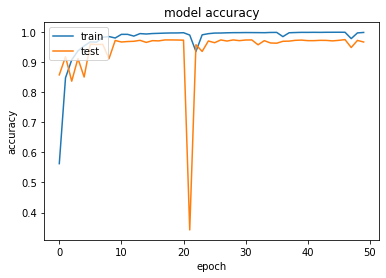

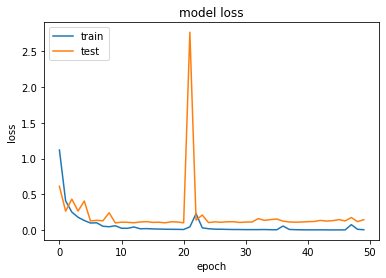

In [316]:
# accuracy plot 
plt.plot(Hist.history['accuracy'])
plt.plot(Hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(Hist.history['loss'])
plt.plot(Hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [317]:
y_pred = W_model.predict(nx_test)

In [318]:
y_test_decode = np.ones(len(y_test))
y_pred_decode = np.ones(len(y_pred))

for i in range(len(y_pred)):
    y_pred_decode[i] = np.argmax(y_pred[i])
    y_test_decode[i] = np.argmax(y_test[i])

In [319]:
mis_index = np.where(y_pred_decode != y_test_decode)

In [320]:
print(classification_report(y_test_decode, y_pred_decode, target_names=faulty_case))

              precision    recall  f1-score   support

      Center       0.99      0.96      0.98       442
       Donut       1.00      1.00      1.00         1
    Edge-Loc       0.73      0.91      0.81       158
   Edge-Ring       1.00      0.83      0.91         6
         Loc       0.73      0.79      0.76       109
   Near-full       1.00      1.00      1.00        11
      Random       0.85      0.83      0.84        35
     Scratch       0.79      0.56      0.65        27
        none       0.99      0.98      0.99      2977

    accuracy                           0.97      3766
   macro avg       0.90      0.87      0.88      3766
weighted avg       0.97      0.97      0.97      3766



Confusion matrix, without normalization
[[ 426    0    3    0    8    0    0    0    5]
 [   0    1    0    0    0    0    0    0    0]
 [   1    0  144    0    2    0    3    0    8]
 [   0    0    1    5    0    0    0    0    0]
 [   3    0   11    0   86    0    2    0    7]
 [   0    0    0    0    0   11    0    0    0]
 [   0    0    4    0    1    0   29    0    1]
 [   0    0    0    0    5    0    0   15    7]
 [   1    0   33    0   16    0    0    4 2923]]
Normalized confusion matrix
[[9.64e-01 0.00e+00 6.79e-03 0.00e+00 1.81e-02 0.00e+00 0.00e+00 0.00e+00
  1.13e-02]
 [0.00e+00 1.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  0.00e+00]
 [6.33e-03 0.00e+00 9.11e-01 0.00e+00 1.27e-02 0.00e+00 1.90e-02 0.00e+00
  5.06e-02]
 [0.00e+00 0.00e+00 1.67e-01 8.33e-01 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  0.00e+00]
 [2.75e-02 0.00e+00 1.01e-01 0.00e+00 7.89e-01 0.00e+00 1.83e-02 0.00e+00
  6.42e-02]
 [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00

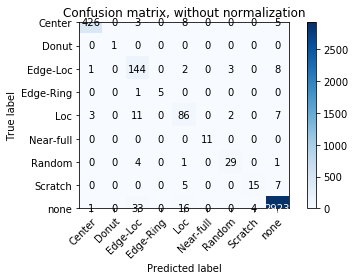

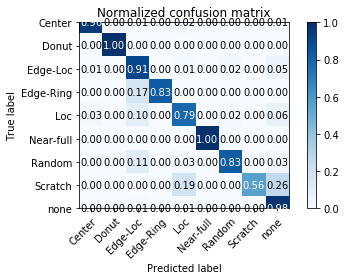

In [321]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_decode, y_pred_decode, classes=faulty_case, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test_decode, y_pred_decode, classes=faulty_case, normalize=True, title='Normalized confusion matrix')

plt.show()

In [1]:
## Error Analysis

In [207]:
#remove channel
px_test = x_test[:,:,:,0]

In [208]:
# number of misclassified 
len(mis_index[0])

113

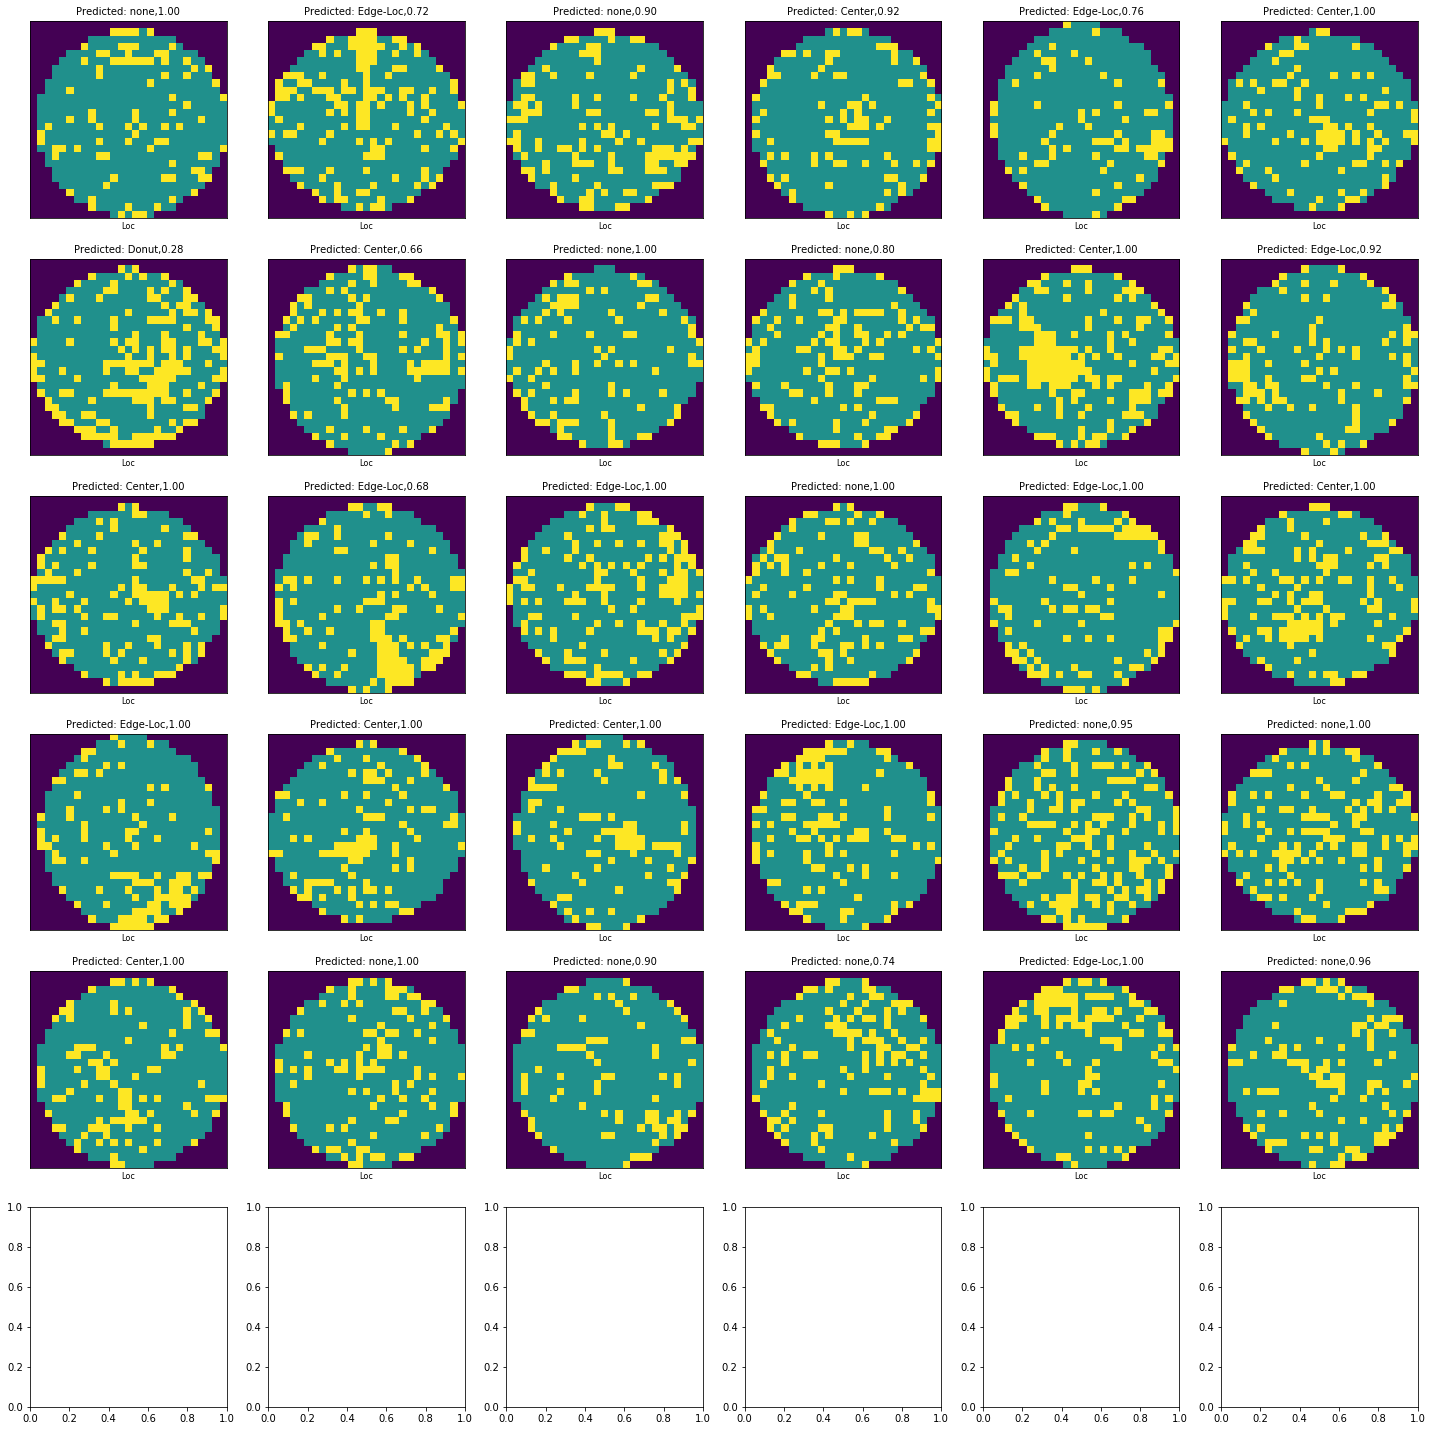

In [209]:
#Draw misclassified image
#Loc (Local)
cnt = 0
fig, ax = plt.subplots(nrows = 6, ncols = 6, figsize=(20, 20))
ax = ax.ravel(order='C')
j=0
for i in range(len(mis_index[0])):
        if faulty_case[int(y_test_decode[mis_index[0][i]])] == 'Loc':
            img = px_test[mis_index[0][i]]
            ax[j].imshow(img)
            ax[j].set_title('Predicted: {},{:.2f}'.format(faulty_case[int(y_pred_decode[mis_index[0][i]])], y_pred[mis_index[0][i]][np.argmax(y_pred[mis_index[0][i]])]), fontsize=10)
            ax[j].set_xlabel(faulty_case[int(y_test_decode[mis_index[0][i]])], fontsize=8)
            ax[j].set_xticks([])
            ax[j].set_yticks([])
            j += 1
        if j == 36:
            break
plt.tight_layout()
plt.show() 

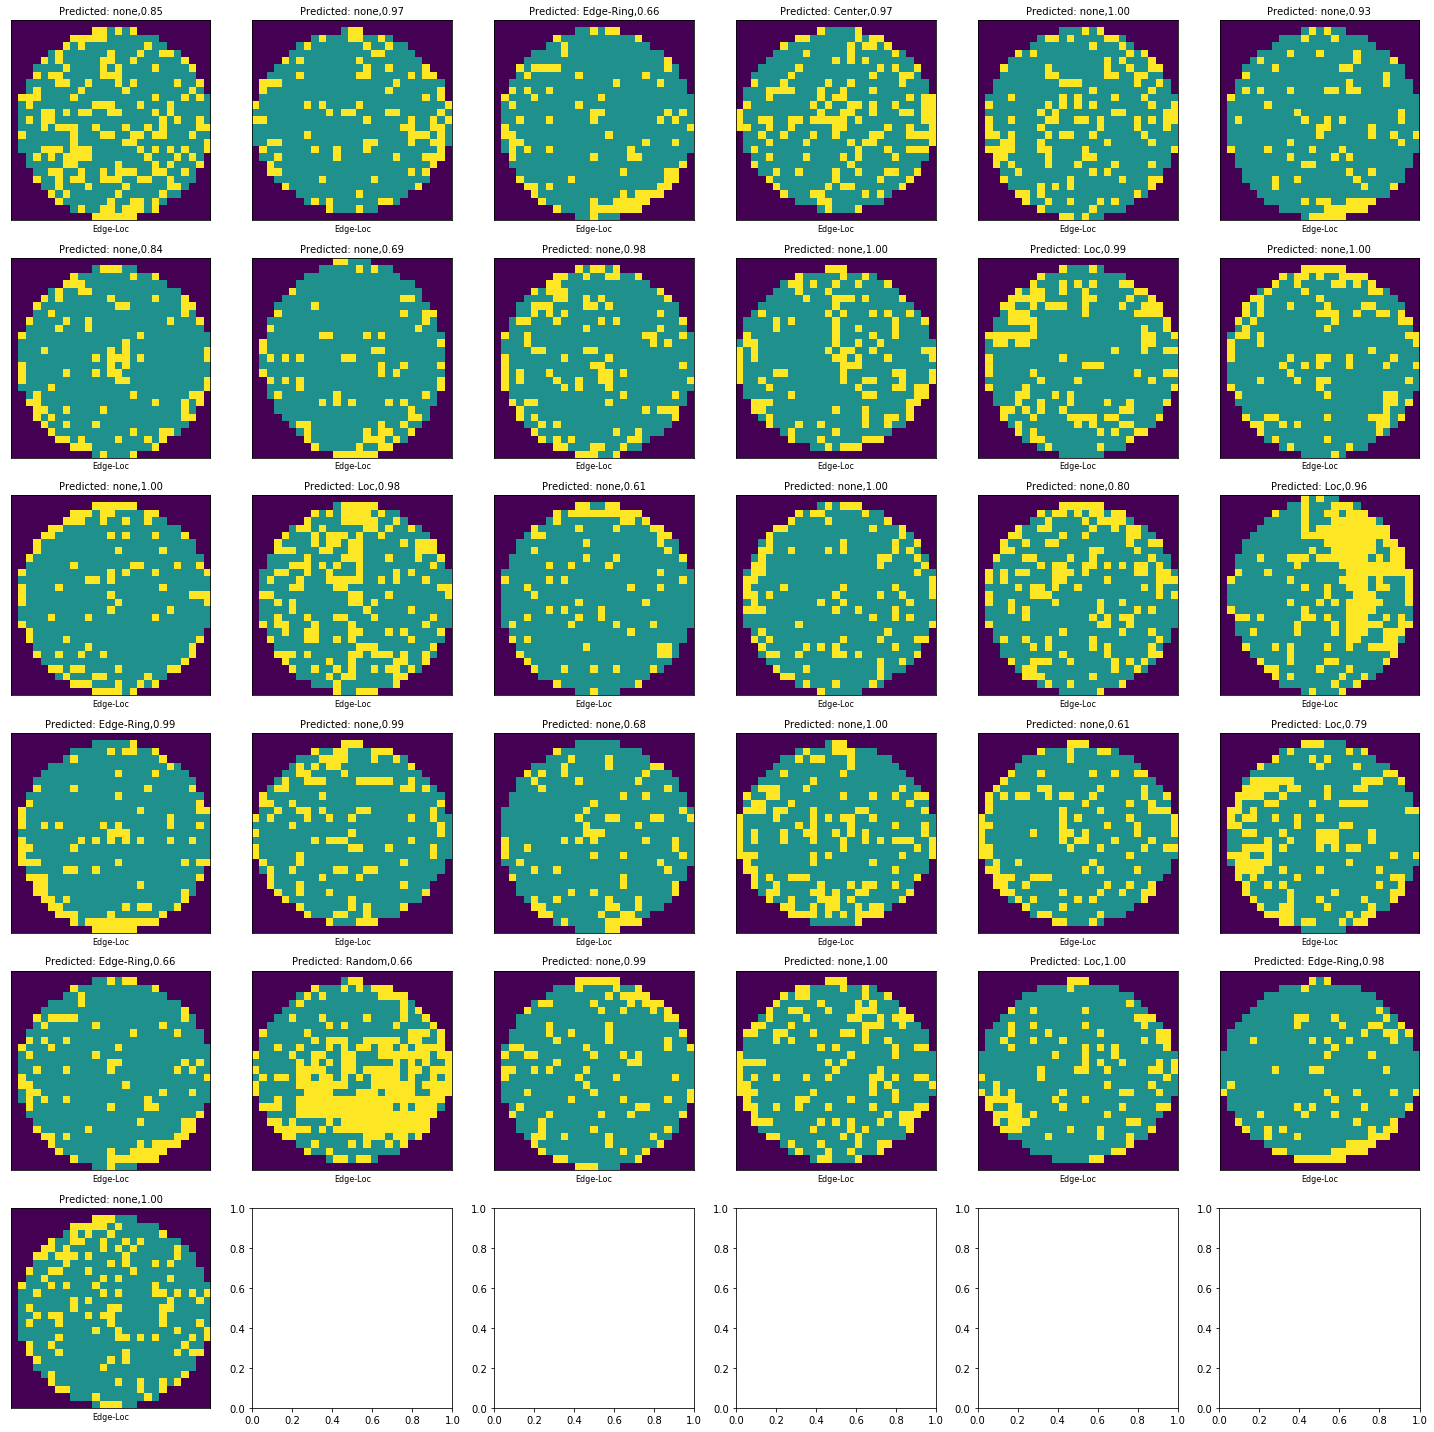

In [210]:
#Draw misclassified image
#Edge-Loc (local)
cnt = 0
fig, ax = plt.subplots(nrows = 6, ncols = 6, figsize=(20, 20))
ax = ax.ravel(order='C')
j=0
for i in range(len(mis_index[0])):
        if faulty_case[int(y_test_decode[mis_index[0][i]])] == 'Edge-Loc':
            img = px_test[mis_index[0][i]]
            ax[j].imshow(img)
            ax[j].set_title('Predicted: {},{:.2f}'.format(faulty_case[int(y_pred_decode[mis_index[0][i]])], y_pred[mis_index[0][i]][np.argmax(y_pred[mis_index[0][i]])]), fontsize=10)
            ax[j].set_xlabel(faulty_case[int(y_test_decode[mis_index[0][i]])], fontsize=8)
            ax[j].set_xticks([])
            ax[j].set_yticks([])
            j += 1
        if j == 36:
            break
plt.tight_layout()
plt.show() 

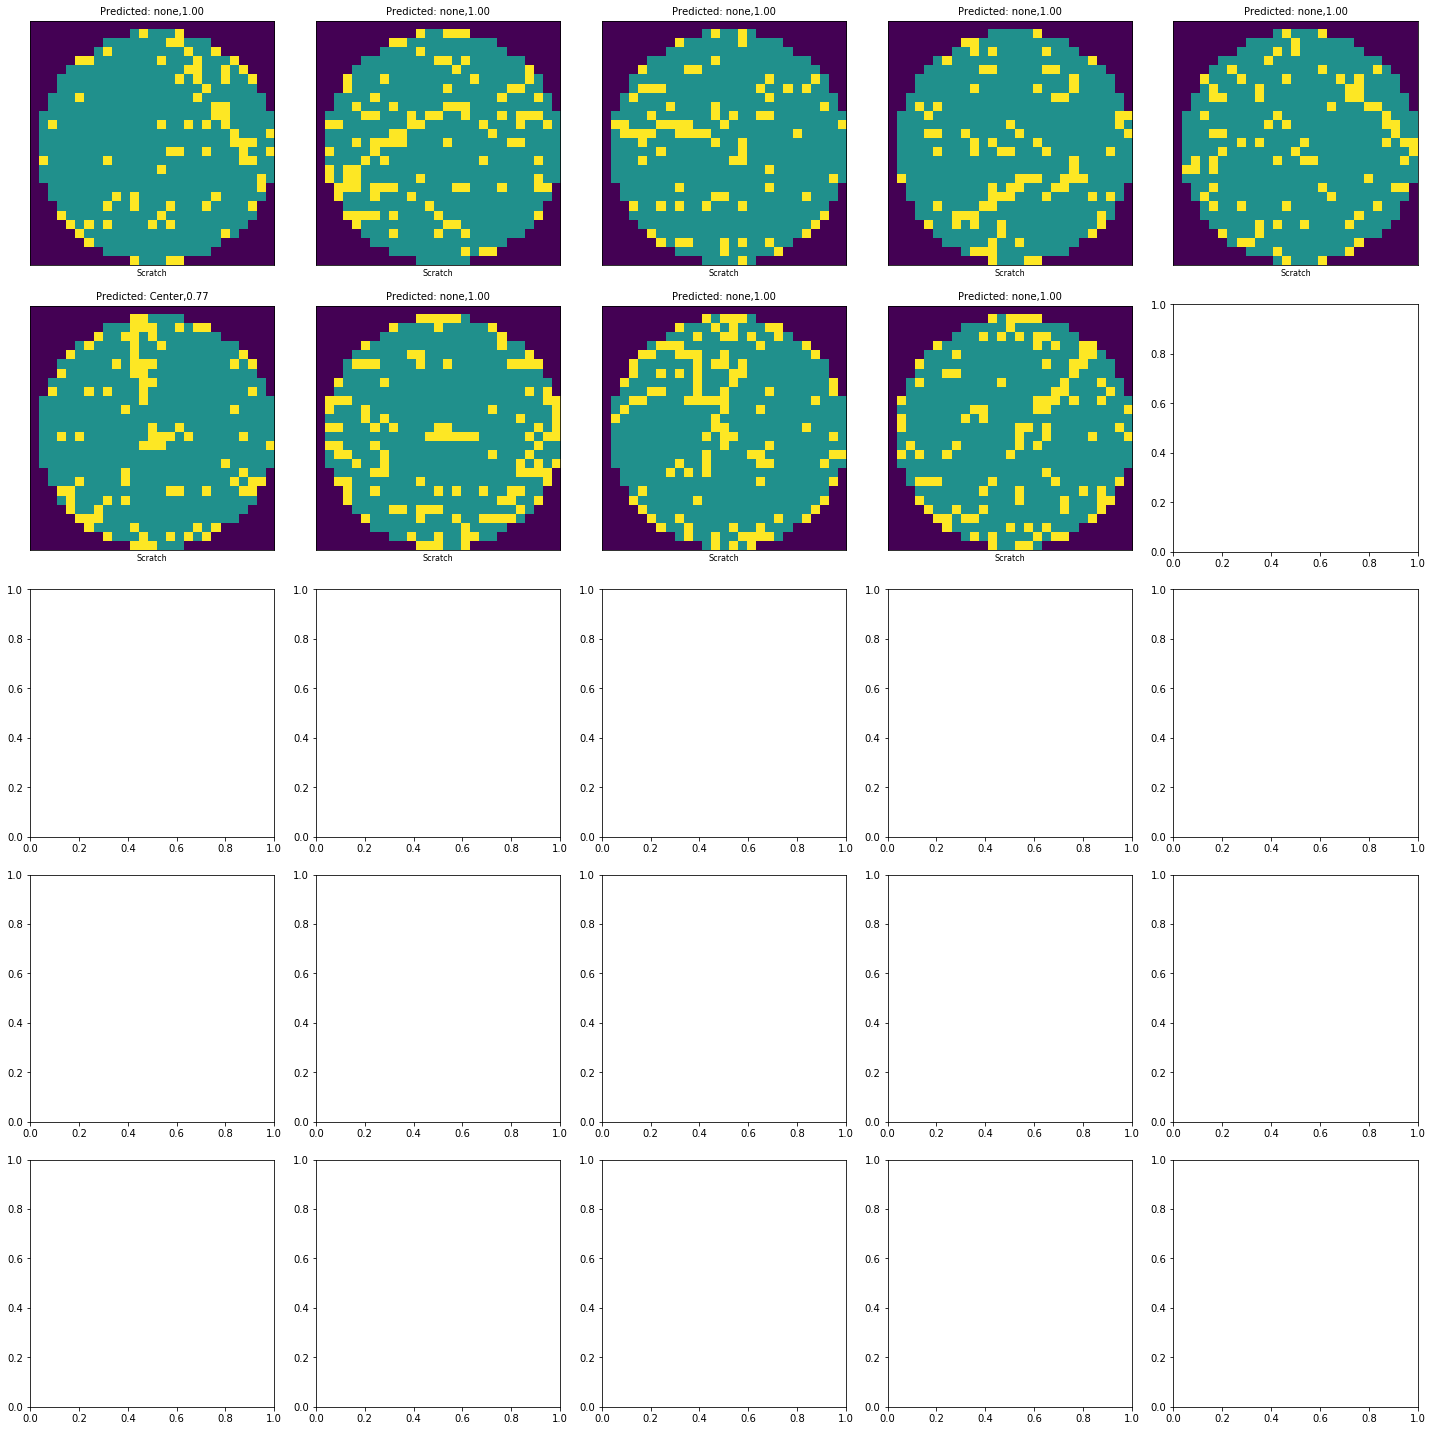

In [211]:
#Draw misclassified image
#Scratch
cnt = 0
fig, ax = plt.subplots(nrows = 5, ncols = 5, figsize=(20, 20))
ax = ax.ravel(order='C')
j=0
for i in range(len(mis_index[0])):
        if faulty_case[int(y_test_decode[mis_index[0][i]])] == 'Scratch':
            img = px_test[mis_index[0][i]]
            ax[j].imshow(img)
            ax[j].set_title('Predicted: {},{:.2f}'.format(faulty_case[int(y_pred_decode[mis_index[0][i]])], y_pred[mis_index[0][i]][np.argmax(y_pred[mis_index[0][i]])]), fontsize=10)
            ax[j].set_xlabel(faulty_case[int(y_test_decode[mis_index[0][i]])], fontsize=8)
            ax[j].set_xticks([])
            ax[j].set_yticks([])
            j += 1
        if j == 25:
            break
plt.tight_layout()
plt.show() 

In [212]:
for i in range (len(mis_index[0])):
    if faulty_case[int(y_test_decode[mis_index[0][i]])] == 'Donut':
        # plot Donut fault data
        plt.imshow(px_test[mis_index[0][i]])
        plt.title('Predicted: {}, Labeled: {}'.format(faulty_case[int(y_pred_decode[mis_index[0][i]])], faulty_case[int(y_test_decode[mis_index[0][i]])]) )
        plt.xlabel('Prob:{:.2f}'.format(y_pred[mis_index[0][i]][np.argmax(y_pred[mis_index[0][i]])]), fontsize=10)
        plt.show()

# VGG-16 model definition

In [322]:
def VGG16(include_top=True,  pooling=None, classes=9):

    input_shape = (27, 27, 3)
    input_tensor = Input(input_shape)
    
    # Block 1
    x = layers.Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv1')(input_tensor)
    x = layers.Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv2')(x)
    x = layers.MaxPooling2D((2, 2), name='block1_pool')(x)

    # Block 2
    x = layers.Conv2D(128, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv1')(x)
    x = layers.Conv2D(128, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv2')(x)
    x = layers.MaxPooling2D((2, 2), name='block2_pool')(x)

    # Block 3
    x = layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv1')(x)
    x = layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv2')(x)
    x = layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv3')(x)
    x = layers.MaxPooling2D((2, 2), name='block3_pool')(x)

    # Block 4
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv1')(x)
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv2')(x)
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv3')(x)
    x = layers.MaxPooling2D((2, 2), name='block4_pool')(x)

    if include_top:
        # Classification block
        x = layers.Flatten(name='flatten')(x)
        x = layers.Dense(1028, activation='relu', name='fc1')(x)
        x = layers.Dense(1028, activation='relu', name='fc2')(x)
        x = layers.Dense(classes, activation='softmax', name='predictions')(x)
    else:
        if pooling == 'avg':
            x = layers.GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = layers.GlobalMaxPooling2D()(x)

    # Create model.
    model = models.Model(input_tensor, x, name='vgg16') 

    return model

In [323]:
VGG_model = VGG16(include_top=True,  pooling=None, classes=9)

In [324]:
VGG_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        (None, 27, 27, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 27, 27, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 27, 27, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 13, 13, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 13, 13, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 13, 13, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 6, 6, 128)         0     

In [325]:
VGG_model.compile(optimizer= optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [326]:
VGG_Hist = VGG_model.fit(nsx_train, y_train, epochs=50, validation_data=[nx_test, y_test], batch_size=900, shuffle=True)

Train on 97043 samples, validate on 3766 samples
Epoch 1/50
97043/97043 [==============================] - 27s 278us/step - loss: 1.6310 - accuracy: 0.3434 - val_loss: 1.1621 - val_accuracy: 0.1511
Epoch 2/50
97043/97043 [==============================] - 21s 220us/step - loss: 0.4403 - accuracy: 0.8384 - val_loss: 0.1882 - val_accuracy: 0.9533
Epoch 3/50
97043/97043 [==============================] - 21s 211us/step - loss: 0.0661 - accuracy: 0.9823 - val_loss: 0.1619 - val_accuracy: 0.9681
Epoch 4/50
97043/97043 [==============================] - 21s 212us/step - loss: 0.0269 - accuracy: 0.9923 - val_loss: 0.2533 - val_accuracy: 0.9320
Epoch 5/50
97043/97043 [==============================] - 21s 212us/step - loss: 0.0139 - accuracy: 0.9963 - val_loss: 0.1833 - val_accuracy: 0.9700
Epoch 6/50
97043/97043 [==============================] - 21s 212us/step - loss: 0.0388 - accuracy: 0.9881 - val_loss: 0.1474 - val_accuracy: 0.9636
Epoch 7/50
97043/97043 [==============================] -

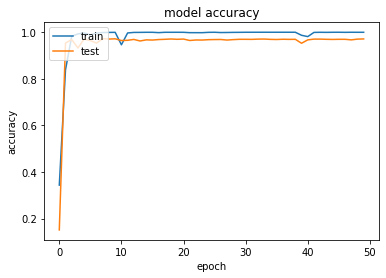

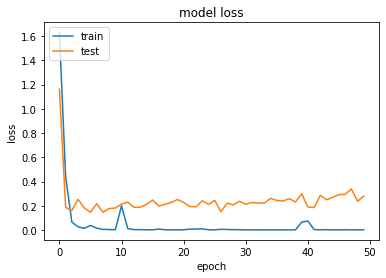

In [327]:
# accuracy plot 
plt.plot(VGG_Hist.history['accuracy'])
plt.plot(VGG_Hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(VGG_Hist.history['loss'])
plt.plot(VGG_Hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [328]:
vy_pred = VGG_model.predict(nx_test)

In [329]:
vy_test_decode = np.ones(len(y_test))
vy_pred_decode = np.ones(len(vy_pred))

for i in range(len(vy_pred)):
    vy_pred_decode[i] = np.argmax(vy_pred[i])
    vy_test_decode[i] = np.argmax(y_test[i])

In [330]:
vmis_index = np.where(vy_pred_decode != vy_test_decode)

In [331]:
print(classification_report(vy_test_decode, vy_pred_decode, target_names=faulty_case))

              precision    recall  f1-score   support

      Center       0.98      0.99      0.99       442
       Donut       1.00      1.00      1.00         1
    Edge-Loc       0.87      0.82      0.85       158
   Edge-Ring       0.86      1.00      0.92         6
         Loc       0.85      0.66      0.74       109
   Near-full       0.90      0.82      0.86        11
      Random       0.86      0.86      0.86        35
     Scratch       0.83      0.37      0.51        27
        none       0.98      0.99      0.99      2977

    accuracy                           0.97      3766
   macro avg       0.90      0.83      0.86      3766
weighted avg       0.97      0.97      0.97      3766



Confusion matrix, without normalization
[[ 437    0    0    0    0    0    0    0    5]
 [   0    1    0    0    0    0    0    0    0]
 [   0    0  130    1    3    1    2    0   21]
 [   0    0    0    6    0    0    0    0    0]
 [   3    0   10    0   72    0    3    1   20]
 [   0    0    2    0    0    9    0    0    0]
 [   0    0    2    0    2    0   30    0    1]
 [   1    0    0    0    2    0    0   10   14]
 [   4    0    5    0    6    0    0    1 2961]]
Normalized confusion matrix
[[9.89e-01 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  1.13e-02]
 [0.00e+00 1.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  0.00e+00]
 [0.00e+00 0.00e+00 8.23e-01 6.33e-03 1.90e-02 6.33e-03 1.27e-02 0.00e+00
  1.33e-01]
 [0.00e+00 0.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  0.00e+00]
 [2.75e-02 0.00e+00 9.17e-02 0.00e+00 6.61e-01 0.00e+00 2.75e-02 9.17e-03
  1.83e-01]
 [0.00e+00 0.00e+00 1.82e-01 0.00e+00 0.00e+00 8.18e-01 0.00e+00 0.00

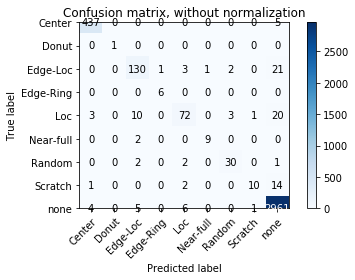

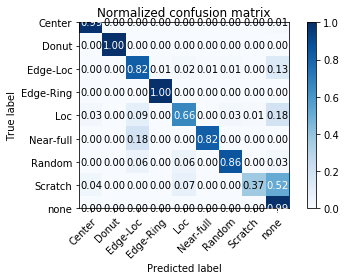

In [332]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(vy_test_decode, vy_pred_decode, classes=faulty_case, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(vy_test_decode, vy_pred_decode, classes=faulty_case, normalize=True, title='Normalized confusion matrix')

plt.show()

# ResNet50

In [90]:
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.initializers import glorot_uniform

In [91]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f,f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1,1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [92]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###

    # Second component of main path (≈3 lines)
    X = Conv2D(F2, (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(F3, (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [93]:
def ResNet50(input_shape = (27, 27, 3), classes = 9):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((1, 1))(X_input)
    
    # Stage 1
    X = Conv2D(64, (3, 3), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [32,32,128], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [32,32,128], stage=2, block='b')
    X = identity_block(X, 3, [32,32,128], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [64,64,256], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [64,64,256], stage=3, block='b')
    X = identity_block(X, 3, [64,64,256], stage=3, block='c')
    X = identity_block(X, 3, [64,64,256], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [128,128,512], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [128,128,512], stage=4, block='b')
    X = identity_block(X, 3, [128,128,512], stage=4, block='c')
    X = identity_block(X, 3, [128,128,512], stage=4, block='d')
    X = identity_block(X, 3, [128,128,512], stage=4, block='e')
    X = identity_block(X, 3, [128,128,512], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=5, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size=(2,2), name = "avg_pool")(X)
    
    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = models.Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [96]:
Rmodel0 = ResNet50(input_shape = (27, 27, 3), classes = 9)

In [97]:
Rmodel0.compile(optimizer= optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [98]:
Resnet_hist = Rmodel0.fit(nsx_train, y_train, epochs=30, validation_data=[nx_test, y_test], batch_size = 700, shuffle=True)

Train on 96898 samples, validate on 3766 samples
Epoch 1/30
96898/96898 [==============================] - 41s 422us/step - loss: 0.2261 - accuracy: 0.9260 - val_loss: 7.3048 - val_accuracy: 0.0361
Epoch 2/30
96898/96898 [==============================] - 33s 342us/step - loss: 0.0212 - accuracy: 0.9936 - val_loss: 8.3215 - val_accuracy: 0.0743
Epoch 3/30
96898/96898 [==============================] - 32s 335us/step - loss: 0.0124 - accuracy: 0.9967 - val_loss: 9.1676 - val_accuracy: 0.1628
Epoch 4/30
96898/96898 [==============================] - 33s 342us/step - loss: 0.0119 - accuracy: 0.9965 - val_loss: 0.5341 - val_accuracy: 0.8755
Epoch 5/30
96898/96898 [==============================] - 35s 357us/step - loss: 0.0155 - accuracy: 0.9955 - val_loss: 0.2945 - val_accuracy: 0.9519
Epoch 6/30
96898/96898 [==============================] - 34s 355us/step - loss: 0.0074 - accuracy: 0.9980 - val_loss: 0.4951 - val_accuracy: 0.9517
Epoch 7/30
96898/96898 [==============================] -

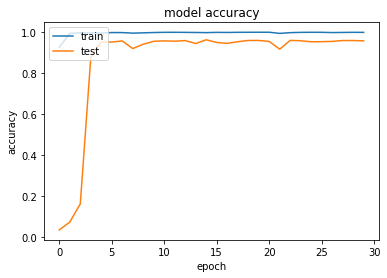

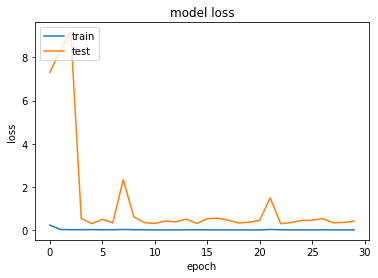

In [99]:
# accuracy plot 
plt.plot(Resnet_hist.history['accuracy'])
plt.plot(Resnet_hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(Resnet_hist.history['loss'])
plt.plot(Resnet_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [100]:
resy_pred = Rmodel0.predict(nx_test)

In [101]:
resy_test_decode = np.ones(len(y_test))
resy_pred_decode = np.ones(len(resy_pred))

for i in range(len(resy_pred)):
    resy_pred_decode[i] = np.argmax(resy_pred[i])
    resy_test_decode[i] = np.argmax(y_test[i])

In [102]:
resmis_index = np.where(resy_pred_decode != resy_test_decode)

In [103]:
print(classification_report(resy_test_decode, resy_pred_decode, target_names=faulty_case))

              precision    recall  f1-score   support

      Center       0.97      0.96      0.97       472
       Donut       0.33      1.00      0.50         1
    Edge-Loc       0.90      0.69      0.78       151
   Edge-Ring       1.00      0.71      0.83         7
         Loc       0.91      0.52      0.66       132
   Near-full       1.00      0.89      0.94         9
      Random       0.87      0.76      0.81        34
     Scratch       1.00      0.10      0.17        21
        none       0.96      1.00      0.98      2939

    accuracy                           0.96      3766
   macro avg       0.88      0.74      0.74      3766
weighted avg       0.96      0.96      0.95      3766



Confusion matrix, without normalization
[[ 455    0    1    0    0    0    0    0   16]
 [   0    1    0    0    0    0    0    0    0]
 [   0    1  104    0    1    0    4    0   41]
 [   0    0    1    5    0    0    0    0    1]
 [  13    1    4    0   68    0    0    0   46]
 [   0    0    1    0    0    8    0    0    0]
 [   1    0    4    0    3    0   26    0    0]
 [   0    0    0    0    2    0    0    2   17]
 [   0    0    1    0    1    0    0    0 2937]]
Normalized confusion matrix
[[9.63983051e-01 0.00000000e+00 2.11864407e-03 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  3.38983051e-02]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 6.62251656e-03 6.88741722e-01 0.00000000e+00
  6.62251656e-03 0.00000000e+00 2.64900662e-02 0.00000000e+00
  2.71523179e-01]
 [0.00000000e+00 0.00000000e+00 1.42857143e-01 7.14285714e-01
  0.0000000

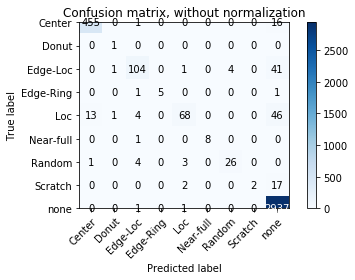

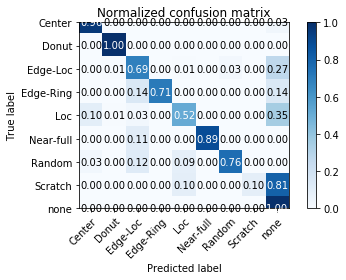

In [104]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(resy_test_decode, resy_pred_decode, classes=faulty_case, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(resy_test_decode, resy_pred_decode, classes=faulty_case, normalize=True, title='Normalized confusion matrix')

plt.show()


# Data Augmentation by Rotating!


In [106]:
x_train_temp.shape, y_train_temp.shape

((15063, 27, 27), (15063, 1))

In [107]:
#Training Data augmentation by rotating
rot_X = np.ones((1, 27, 27))
r_x = np.ones((1, 27, 27))
y_label = list()

for i in range(len(faulty_case)):
    if(len(y_train_temp[y_train_temp==faulty_case[i]]) < 10000):
        for j in range(10000 - len(y_train_temp[y_train_temp==faulty_case[i]])):
            n = np.random.randint(len(y_train_temp[y_train_temp==faulty_case[i]]))
            r_x = ndimage.rotate(x_train_temp[np.where(y_train_temp==faulty_case[i])[0][n]], np.random.randint(360), axes=(0,1), mode='constant', order = 0, reshape=False)
            rot_X = np.concatenate((rot_X, r_x.reshape(1,27,27)))
            y_label.append(y_train_temp[y_train_temp==faulty_case[i]][0])

In [108]:
rx = rot_X[1:]
ry = np.array(y_label).reshape((-1,1))

In [109]:
dx_train = np.concatenate((x_train_temp, rx[0:]))
dy_train = np.concatenate((y_train_temp, ry))

In [110]:
faulty_case = np.unique(dy_train)
print('Faulty case list : {}'.format(faulty_case))

Faulty case list : ['Center' 'Donut' 'Edge-Loc' 'Edge-Ring' 'Loc' 'Near-full' 'Random'
 'Scratch' 'none']


In [111]:
for f in faulty_case :
    print('{} : {}'.format(f, len(dy_train[dy_train==f])))

Center : 10000
Donut : 10000
Edge-Loc : 10000
Edge-Ring : 10000
Loc : 10000
Near-full : 10000
Random : 10000
Scratch : 10000
none : 11856


In [112]:
#x_train: add channel
dx_train = dx_train.reshape((-1, 27, 27, 1))

In [113]:
#check new x dimension
dx_train.shape, dy_train.shape

((91856, 27, 27, 1), (91856, 1))

In [114]:
# One-hot-Encoding faulty categorical variable as channel
dnx_train = np.zeros((len(dx_train), 27, 27, 3))

for w in range(len(dx_train)):
    for i in range(27):
        for j in range(27):
            dnx_train[w, i, j, int(dx_train[w, i, j])] = 1

In [115]:
dnx_train.shape

(91856, 27, 27, 3)

In [116]:
# make string label data to numerical data
for i, l in enumerate(faulty_case):
    dy_train[dy_train==l] = i
    
# one-hot-encoding
dy_train = to_categorical(dy_train)

In [117]:
dy_train.shape

(91856, 9)

In [118]:
nx_test.shape, y_test.shape

((3766, 27, 27, 3), (3766, 9))

# Simplified VGG model

In [135]:
lamb = 0.001
drt = 0.4

In [136]:
def mcreate_model():
    input_shape = (27, 27, 3)
    input_tensor = Input(input_shape)
    
    #initializer: glorot_normal, glorot_uniform, he_normal, he_uniform

    conv_1 = layers.Conv2D(32, (3,3), kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l2(lamb), activation='relu',padding='same')(input_tensor)
    conv_2 = layers.Conv2D(64, (3,3), kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l2(lamb), activation='relu',padding='same')(conv_1)
    pool_1 = layers.MaxPool2D((2,2), name = 'max_pool1')(conv_2)

    conv_3 = layers.Conv2D(128, (3,3), kernel_initializer='glorot_uniform',activation='relu', kernel_regularizer=regularizers.l2(lamb), padding='same')(pool_1)
    conv_4 = layers.Conv2D(256, (3,3), kernel_initializer='glorot_uniform',activation='relu', kernel_regularizer=regularizers.l2(lamb), padding='same')(conv_3)
    pool_2 = layers.MaxPool2D((2,2), name = 'max_pool2')(conv_4)

    flat = layers.Flatten()(pool_2)

    dense_1 = layers.Dense(512, activation='relu')(flat)
    drop_1 = layers.Dropout(drt)(dense_1)
    dense_2 = layers.Dense(256, activation='relu')(drop_1)
    output_tensor = layers.Dense(9, activation='softmax')(dense_2)

    model = models.Model(input_tensor, output_tensor)
 
    return model

In [137]:
AF_model = mcreate_model()

In [138]:
AF_model.compile(optimizer= optimizers.Adam(learning_rate = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [139]:
AF_Hist = AF_model.fit(dnx_train, dy_train, epochs=50, validation_data=[nx_test, y_test], batch_size=900, shuffle=True)

Train on 91839 samples, validate on 3766 samples
Epoch 1/50
91839/91839 [==============================] - 12s 135us/step - loss: 0.8442 - accuracy: 0.7504 - val_loss: 0.3234 - val_accuracy: 0.9541
Epoch 2/50
91839/91839 [==============================] - 10s 110us/step - loss: 0.4353 - accuracy: 0.8933 - val_loss: 0.2925 - val_accuracy: 0.9456
Epoch 3/50
91839/91839 [==============================] - 10s 106us/step - loss: 0.3520 - accuracy: 0.9161 - val_loss: 0.2570 - val_accuracy: 0.9586
Epoch 4/50
91839/91839 [==============================] - 10s 106us/step - loss: 0.2952 - accuracy: 0.9323 - val_loss: 0.2067 - val_accuracy: 0.9681
Epoch 5/50
91839/91839 [==============================] - 10s 107us/step - loss: 0.2585 - accuracy: 0.9422 - val_loss: 0.2593 - val_accuracy: 0.9620
Epoch 6/50
91839/91839 [==============================] - 10s 108us/step - loss: 0.2455 - accuracy: 0.9459 - val_loss: 0.1886 - val_accuracy: 0.9676
Epoch 7/50
91839/91839 [==============================] -

In [140]:
apred = AF_model.evaluate(x = nx_test, y = y_test)
print()
print ("Loss = " + str(apred[0]))
print ("Test Accuracy = " + str(apred[1]))

3766/3766 [==============================] - 1s 198us/step

Loss = 0.21053093920283283
Test Accuracy = 0.973712146282196


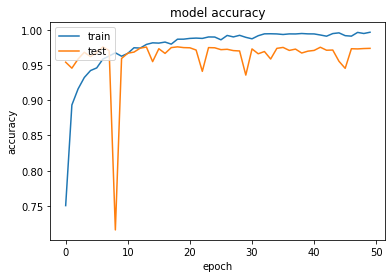

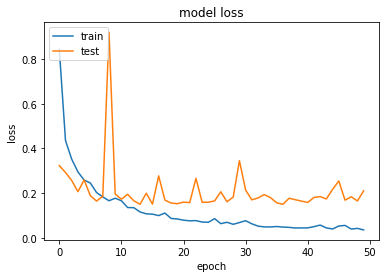

In [141]:
# accuracy plot 
plt.plot(AF_Hist.history['accuracy'])
plt.plot(AF_Hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(AF_Hist.history['loss'])
plt.plot(AF_Hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [142]:
ay_pred = AF_model.predict(nx_test)

In [143]:
ay_test_decode = np.ones(len(y_test))
ay_pred_decode = np.ones(len(ay_pred))

for i in range(len(ay_pred)):
    ay_pred_decode[i] = np.argmax(ay_pred[i])
    ay_test_decode[i] = np.argmax(y_test[i])

In [144]:
amis_index = np.where(ay_pred_decode != ay_test_decode)

In [145]:
print(classification_report(ay_test_decode, ay_pred_decode, target_names=faulty_case))

              precision    recall  f1-score   support

      Center       0.99      0.99      0.99       475
       Donut       0.50      1.00      0.67         1
    Edge-Loc       0.89      0.82      0.86       154
   Edge-Ring       0.80      0.92      0.86        13
         Loc       0.88      0.63      0.73       111
   Near-full       1.00      1.00      1.00        13
      Random       0.80      0.89      0.84        27
     Scratch       1.00      0.25      0.40        16
        none       0.98      1.00      0.99      2956

    accuracy                           0.97      3766
   macro avg       0.87      0.83      0.81      3766
weighted avg       0.97      0.97      0.97      3766



Confusion matrix, without normalization
[[ 470    0    0    0    1    0    0    0    4]
 [   0    1    0    0    0    0    0    0    0]
 [   1    0  127    3    4    0    3    0   16]
 [   0    0    0   12    0    0    0    0    1]
 [   4    0    7    0   70    0    3    0   27]
 [   0    0    0    0    0   13    0    0    0]
 [   1    1    0    0    0    0   24    0    1]
 [   0    0    2    0    1    0    0    4    9]
 [   0    0    6    0    4    0    0    0 2946]]
Normalized confusion matrix
[[0.98947368 0.         0.         0.         0.00210526 0.
  0.         0.         0.00842105]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.00649351 0.         0.82467532 0.01948052 0.02597403 0.
  0.01948052 0.         0.1038961 ]
 [0.         0.         0.         0.92307692 0.         0.
  0.         0.         0.07692308]
 [0.03603604 0.         0.06306306 0.         0.63063063 0.
  0.02702703 0.         0.24324324]
 [0.         0.    

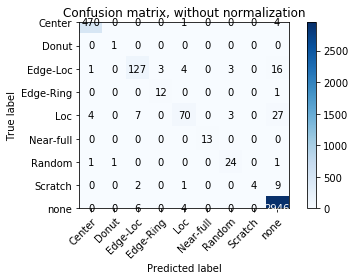

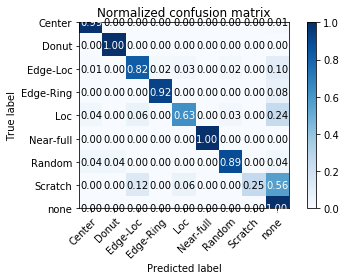

In [146]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(ay_test_decode, ay_pred_decode, classes=faulty_case, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(ay_test_decode, ay_pred_decode, classes=faulty_case, normalize=True, title='Normalized confusion matrix')

plt.show()

# GAP model 

In [119]:
def mGAP_create_model():
    input_shape = (27, 27, 3)
    input_tensor = Input(input_shape)
    
    #initializer: glorot_normal, glorot_uniform, he_normal, he_uniform

    conv_1 = layers.Conv2D(32, (3,3), kernel_initializer='he_normal', activation='relu',padding='same')(input_tensor)
    conv_2 = layers.Conv2D(64, (3,3), kernel_initializer='he_normal', activation='relu',padding='same')(conv_1)

    pool_1 = layers.MaxPool2D((2,2), name = 'max_pool1')(conv_2)

    conv_3 = layers.Conv2D(128, (3,3), kernel_initializer='he_normal',activation='relu', padding='same')(pool_1)
    conv_4 = layers.Conv2D(256, (3,3), kernel_initializer='he_normal',activation='relu', padding='same')(conv_3)

    pool_2 = layers.GlobalAveragePooling2D()(conv_4) #GAP layer

    dense_1 = layers.Dense(512, activation='relu')(pool_2)
    drop_1 = layers.Dropout(0.1)(dense_1)
    dense_2 = layers.Dense(256, activation='relu')(drop_1)
    output_tensor = layers.Dense(9, activation='softmax')(dense_2)

    model = models.Model(input_tensor, output_tensor)
 
    return model

In [120]:
WF_model = mGAP_create_model()

In [121]:
WF_model.compile(optimizer= optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [122]:
WF_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 27, 27, 3)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 32)        896       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 27, 27, 64)        18496     
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 128)       73856     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 13, 13, 256)       295168    
_________________________________________________________________
global_average_pooling2d_1 ( (None, 256)               0   

In [123]:
Hist2 = WF_model.fit(dnx_train, dy_train, epochs=50, validation_data=[nx_test, y_test], batch_size=900, shuffle=True)

Train on 91856 samples, validate on 3766 samples
Epoch 1/50
91856/91856 [==============================] - 11s 121us/step - loss: 1.1780 - accuracy: 0.5391 - val_loss: 0.6227 - val_accuracy: 0.8168
Epoch 2/50
91856/91856 [==============================] - 9s 101us/step - loss: 0.5730 - accuracy: 0.7850 - val_loss: 0.1627 - val_accuracy: 0.9506
Epoch 3/50
91856/91856 [==============================] - 9s 100us/step - loss: 0.3779 - accuracy: 0.8588 - val_loss: 0.2895 - val_accuracy: 0.9182
Epoch 4/50
91856/91856 [==============================] - 9s 100us/step - loss: 0.3025 - accuracy: 0.8871 - val_loss: 0.1298 - val_accuracy: 0.9602
Epoch 5/50
91856/91856 [==============================] - 9s 100us/step - loss: 0.2610 - accuracy: 0.9016 - val_loss: 0.2283 - val_accuracy: 0.9270
Epoch 6/50
91856/91856 [==============================] - 9s 101us/step - loss: 0.2377 - accuracy: 0.9111 - val_loss: 0.1998 - val_accuracy: 0.9320
Epoch 7/50
91856/91856 [==============================] - 9s 1

In [124]:
pred = WF_model.evaluate(x = nx_test, y = y_test)
print()
print ("Loss = " + str(pred[0]))
print ("Test Accuracy = " + str(pred[1]))

3766/3766 [==============================] - 1s 140us/step

Loss = 0.11878729174688257
Test Accuracy = 0.9734466075897217


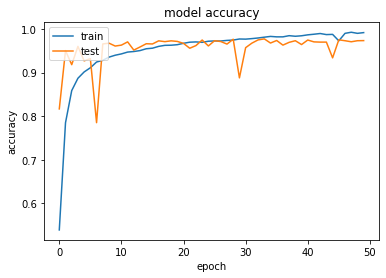

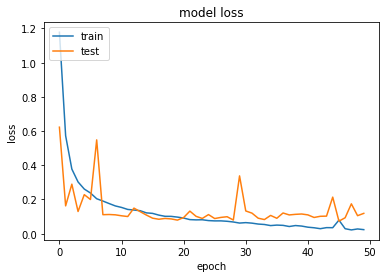

In [125]:
# accuracy plot 
plt.plot(Hist2.history['accuracy'])
plt.plot(Hist2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(Hist2.history['loss'])
plt.plot(Hist2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [126]:
ny_pred = WF_model.predict(nx_test)

In [127]:
ny_test_decode = np.ones(len(y_test))
ny_pred_decode = np.ones(len(ny_pred))

for i in range(len(ny_pred)):
    ny_pred_decode[i] = np.argmax(ny_pred[i])
    ny_test_decode[i] = np.argmax(y_test[i])

In [128]:
nmis_index = np.where(ny_pred_decode != ny_test_decode)

In [129]:
print(classification_report(ny_test_decode, ny_pred_decode, target_names=faulty_case))

              precision    recall  f1-score   support

      Center       0.96      0.98      0.97       472
       Donut       0.50      1.00      0.67         1
    Edge-Loc       0.93      0.87      0.90       151
   Edge-Ring       0.78      1.00      0.88         7
         Loc       0.88      0.67      0.76       132
   Near-full       1.00      1.00      1.00         9
      Random       0.94      0.97      0.96        34
     Scratch       0.56      0.86      0.68        21
        none       0.99      0.99      0.99      2939

    accuracy                           0.97      3766
   macro avg       0.84      0.93      0.87      3766
weighted avg       0.97      0.97      0.97      3766



Confusion matrix, without normalization
[[ 464    0    2    0    0    0    0    0    6]
 [   0    1    0    0    0    0    0    0    0]
 [   0    0  131    1    6    0    1    0   12]
 [   0    0    0    7    0    0    0    0    0]
 [  15    1    3    0   89    0    1    5   18]
 [   0    0    0    0    0    9    0    0    0]
 [   0    0    1    0    0    0   33    0    0]
 [   0    0    0    0    1    0    0   18    2]
 [   6    0    4    1    5    0    0    9 2914]]
Normalized confusion matrix
[[9.83050847e-01 0.00000000e+00 4.23728814e-03 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.27118644e-02]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 8.67549669e-01 6.62251656e-03
  3.97350993e-02 0.00000000e+00 6.62251656e-03 0.00000000e+00
  7.94701987e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
  0.0000000

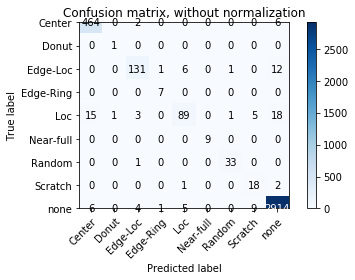

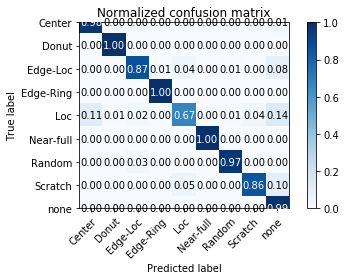

In [130]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(ny_test_decode, ny_pred_decode, classes=faulty_case, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(ny_test_decode, ny_pred_decode, classes=faulty_case, normalize=True, title='Normalized confusion matrix')

plt.show()

In [131]:
# Class Activation Map (CAM)

In [132]:
last_conv_layer = WF_model.get_layer('conv2d_5')

In [133]:
class_weights = WF_model.layers[-1].get_weights()[0]

In [134]:
get_output = K.function([WF_model.input], [last_conv_layer.output, WF_model.layers[-1].output])

In [135]:
[f_conv_outputs, predictions] = get_output([nx_test])

In [136]:
conv_outputs = f_conv_outputs[0,:,:,:]

In [137]:
#Create the class activation map.
cam = np.zeros(dtype = np.float32, shape = conv_outputs.shape[0:2])

In [146]:
for i, w in enumerate(class_weights[:, 1]):
    cam += w * conv_outputs[:,:,i]

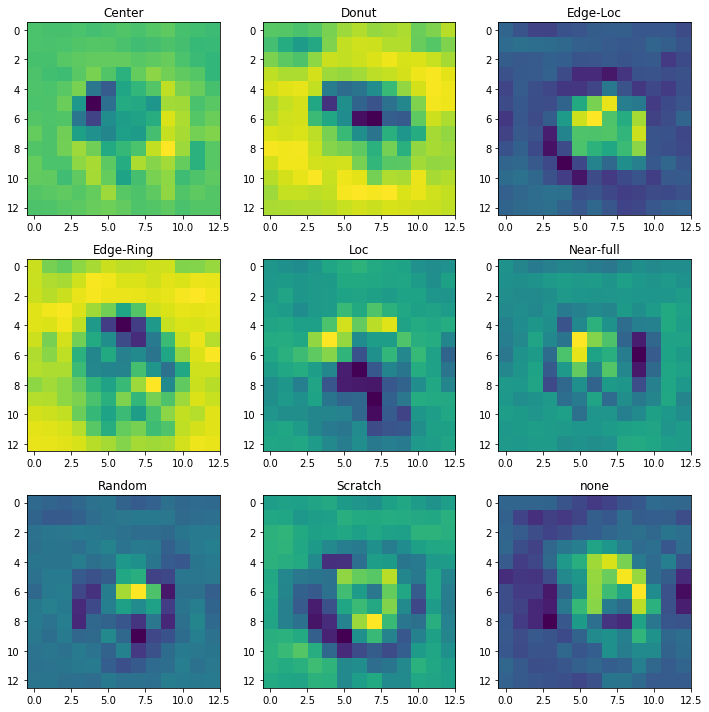

In [144]:
fig, ax = plt.subplots(nrows = 3, ncols = 3, figsize=(10, 10))
ni_cam = np.zeros((9,13,13))
ax = ax.ravel(order='C')
for i in range(9):
    for k, w in enumerate(class_weights[:, i]):
        ni_cam[i] += w * conv_outputs[:, :, k]
    ax[i].imshow(ni_cam[i])
    ax[i].set_title(faulty_case[i])
    k=0
plt.tight_layout()
plt.show()

In [140]:
#remove channel
npx_test = x_test[:,:,:,0]

In [141]:
# number of misclassified 
len(nmis_index[0])

100

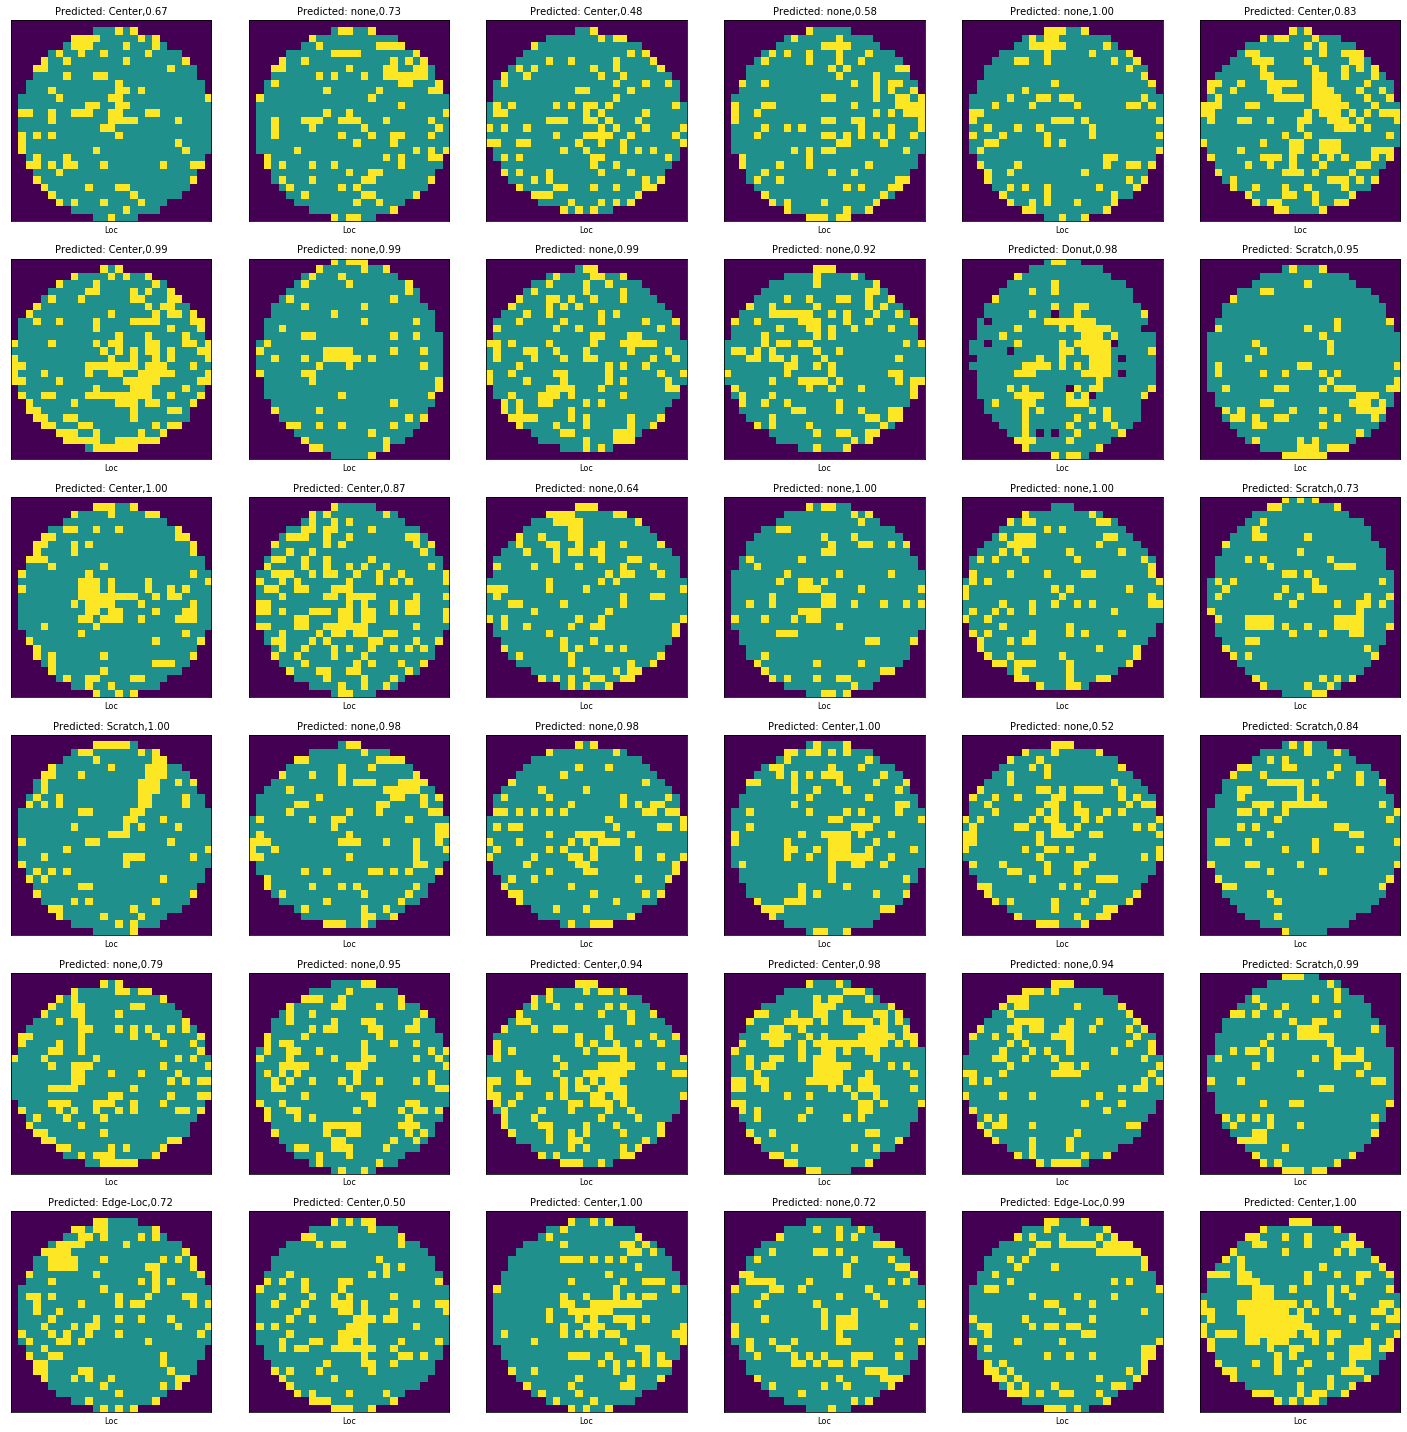

In [142]:
#Draw misclassified image
#Loc (Local)
cnt = 0
fig, ax = plt.subplots(nrows = 6, ncols = 6, figsize=(20, 20))
ax = ax.ravel(order='C')
j=0
for i in range(len(nmis_index[0])):
        if faulty_case[int(ny_test_decode[nmis_index[0][i]])] == 'Loc':
            img = npx_test[nmis_index[0][i]]
            ax[j].imshow(img)
            ax[j].set_title('Predicted: {},{:.2f}'.format(faulty_case[int(ny_pred_decode[nmis_index[0][i]])], ny_pred[nmis_index[0][i]][np.argmax(ny_pred[nmis_index[0][i]])]), fontsize=10)
            ax[j].set_xlabel(faulty_case[int(ny_test_decode[nmis_index[0][i]])], fontsize=8)
            ax[j].set_xticks([])
            ax[j].set_yticks([])
            j += 1
        if j == 36:
            break
plt.tight_layout()
plt.show() 

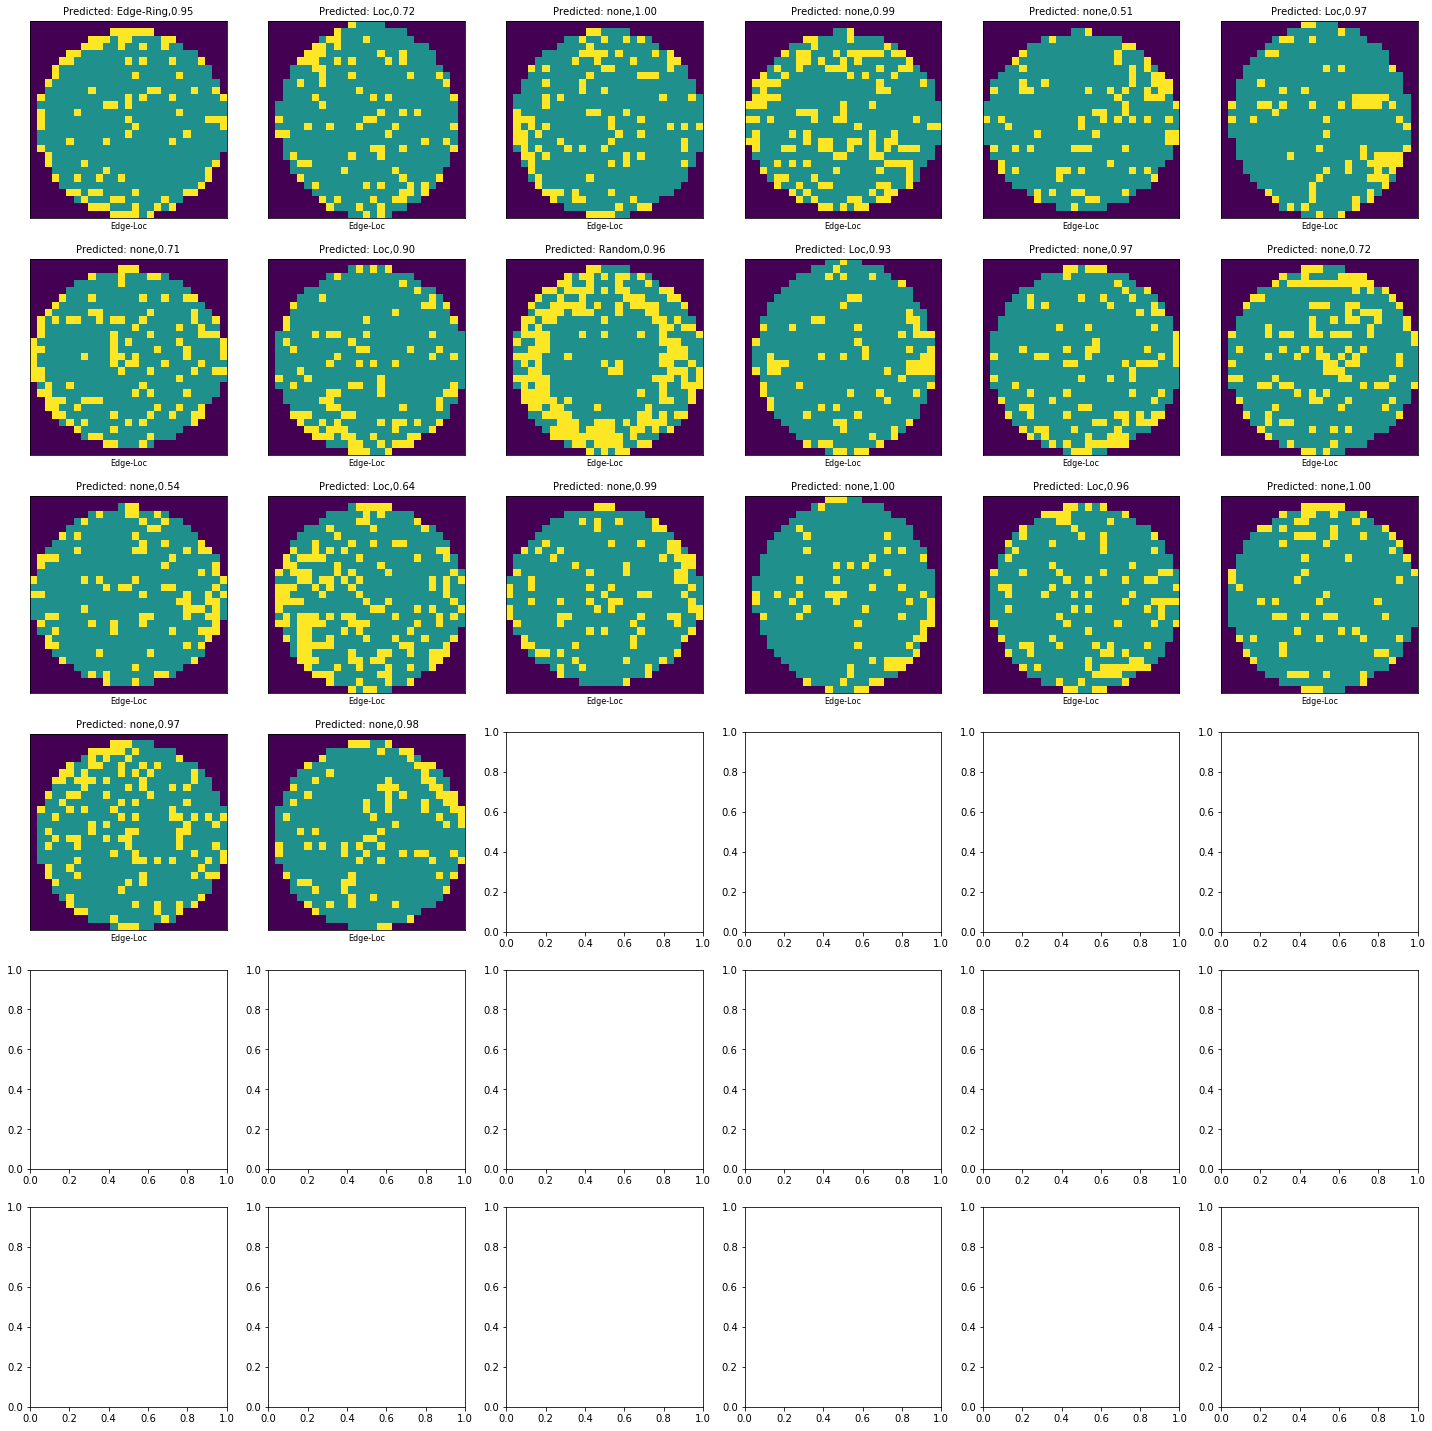

In [143]:
#Draw misclassified image
#Loc (Local)
cnt = 0
fig, ax = plt.subplots(nrows = 6, ncols = 6, figsize=(20, 20))
ax = ax.ravel(order='C')
j=0
for i in range(len(nmis_index[0])):
        if faulty_case[int(ny_test_decode[nmis_index[0][i]])] == 'Edge-Loc':
            img = npx_test[nmis_index[0][i]]
            ax[j].imshow(img)
            ax[j].set_title('Predicted: {},{:.2f}'.format(faulty_case[int(ny_pred_decode[nmis_index[0][i]])], ny_pred[nmis_index[0][i]][np.argmax(ny_pred[nmis_index[0][i]])]), fontsize=10)
            ax[j].set_xlabel(faulty_case[int(ny_test_decode[nmis_index[0][i]])], fontsize=8)
            ax[j].set_xticks([])
            ax[j].set_yticks([])
            j += 1
        if j == 36:
            break
plt.tight_layout()
plt.show() 

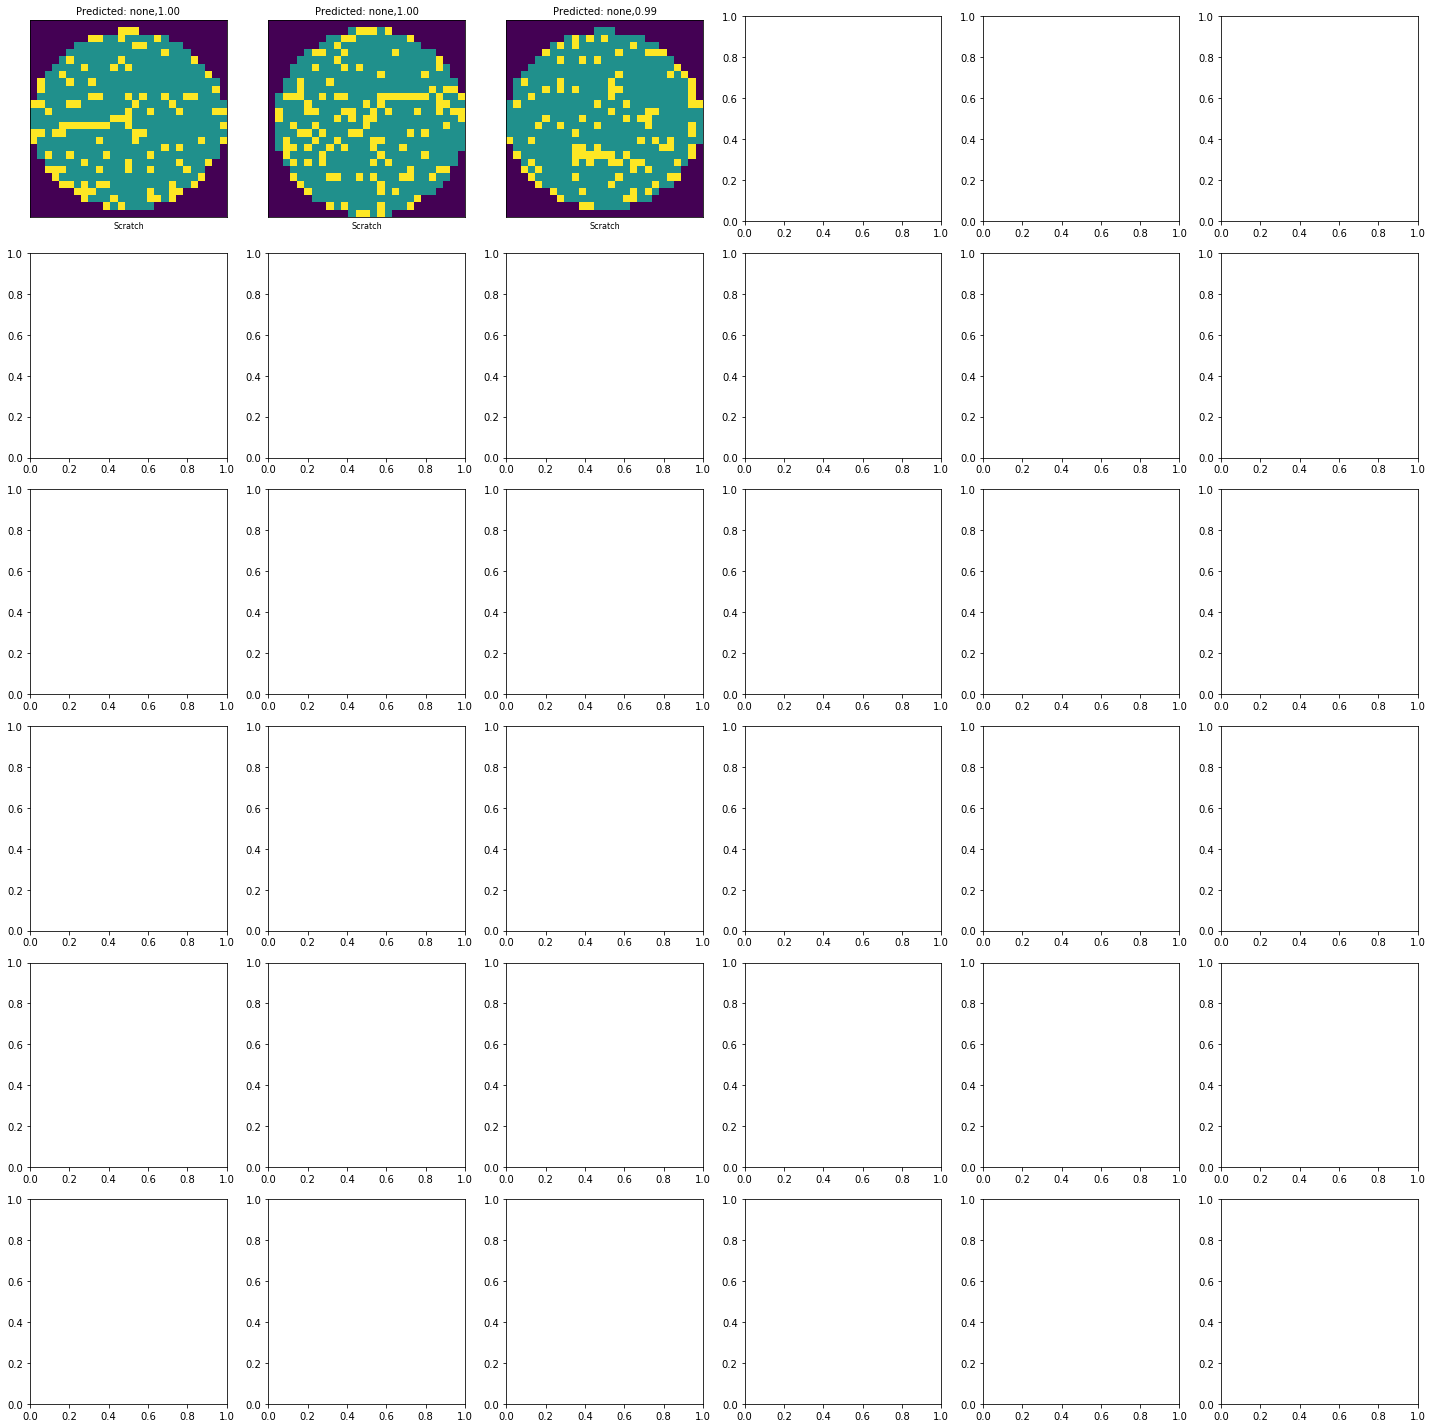

In [280]:
#Draw misclassified image
#Loc (Local)
cnt = 0
fig, ax = plt.subplots(nrows = 6, ncols = 6, figsize=(20, 20))
ax = ax.ravel(order='C')
j=0
for i in range(len(nmis_index[0])):
        if faulty_case[int(ny_test_decode[nmis_index[0][i]])] == 'Scratch':
            img = npx_test[nmis_index[0][i]]
            ax[j].imshow(img)
            ax[j].set_title('Predicted: {},{:.2f}'.format(faulty_case[int(ny_pred_decode[nmis_index[0][i]])], ny_pred[nmis_index[0][i]][np.argmax(ny_pred[nmis_index[0][i]])]), fontsize=10)
            ax[j].set_xlabel(faulty_case[int(ny_test_decode[nmis_index[0][i]])], fontsize=8)
            ax[j].set_xticks([])
            ax[j].set_yticks([])
            j += 1
        if j == 36:
            break
plt.tight_layout()
plt.show() 

# VGG-16 model

In [209]:
def mVGG16(include_top=True,  pooling=None, classes=9):

    input_shape = (27, 27, 3)
    input_tensor = Input(input_shape)
    
    # Block 1
    x = layers.Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv1')(input_tensor)
    x = layers.Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv2')(x)
    x = layers.MaxPooling2D((2, 2), name='block1_pool')(x)

    # Block 2
    x = layers.Conv2D(128, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv1')(x)
    x = layers.Conv2D(128, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv2')(x)
    x = layers.MaxPooling2D((2, 2), name='block2_pool')(x)

    # Block 3
    x = layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv1')(x)
    x = layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv2')(x)
    x = layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv3')(x)
    x = layers.MaxPooling2D((2, 2), name='block3_pool')(x)

    # Block 4
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv1')(x)
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv2')(x)
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv3')(x)
    x = layers.MaxPooling2D((2, 2), name='block4_pool')(x)

    if include_top:
        # Classification block
        x = layers.Flatten(name='flatten')(x)
        x = layers.Dense(1028, activation='relu', name='fc1')(x)
        x = layers.Dense(1028, activation='relu', name='fc2')(x)
        x = layers.Dense(classes, activation='softmax', name='predictions')(x)
    else:
        if pooling == 'avg':
            x = layers.GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = layers.GlobalMaxPooling2D()(x)

    # Create model.
    model = models.Model(input_tensor, x, name='mvgg16') 

    return model

In [210]:
rVGG_model = mVGG16(include_top=True,  pooling=None, classes=9)

In [211]:
rVGG_model.compile(optimizer= optimizers.Adam(learning_rate=0.002), loss='categorical_crossentropy', metrics=['accuracy'])

In [212]:
rVGG_model.summary()

Model: "mvgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 27, 27, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 27, 27, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 27, 27, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 13, 13, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 13, 13, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 13, 13, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 6, 6, 128)         0    

In [213]:
rVGG_Hist = rVGG_model.fit(dnx_train, dy_train, epochs=50, validation_data=[nx_test, y_test], batch_size=900, shuffle=True)

Train on 91818 samples, validate on 3766 samples
Epoch 1/50
91818/91818 [==============================] - 20s 220us/step - loss: 1.7712 - accuracy: 0.2682 - val_loss: 0.7790 - val_accuracy: 0.8457
Epoch 2/50
91818/91818 [==============================] - 19s 202us/step - loss: 0.8975 - accuracy: 0.6428 - val_loss: 0.8266 - val_accuracy: 0.6745
Epoch 3/50
91818/91818 [==============================] - 19s 204us/step - loss: 0.4132 - accuracy: 0.8560 - val_loss: 0.2088 - val_accuracy: 0.9448
Epoch 4/50
91818/91818 [==============================] - 19s 205us/step - loss: 0.2454 - accuracy: 0.9126 - val_loss: 0.2011 - val_accuracy: 0.9493
Epoch 5/50
91818/91818 [==============================] - 19s 205us/step - loss: 0.2010 - accuracy: 0.9283 - val_loss: 0.1102 - val_accuracy: 0.9673
Epoch 6/50
91818/91818 [==============================] - 19s 205us/step - loss: 0.1670 - accuracy: 0.9407 - val_loss: 0.8575 - val_accuracy: 0.7403
Epoch 7/50
91818/91818 [==============================] -

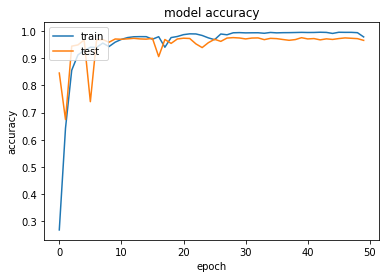

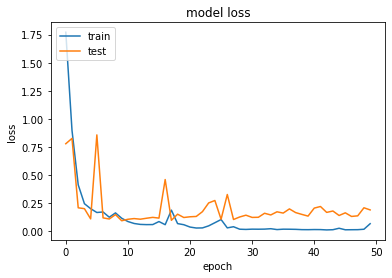

In [214]:
# accuracy plot 
plt.plot(rVGG_Hist.history['accuracy'])
plt.plot(rVGG_Hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(rVGG_Hist.history['loss'])
plt.plot(rVGG_Hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [215]:
rny_pred = rVGG_model.predict(nx_test)

In [216]:
rny_test_decode = np.ones(len(y_test))
rny_pred_decode = np.ones(len(rny_pred))

for i in range(len(rny_pred)):
    rny_pred_decode[i] = np.argmax(rny_pred[i])
    rny_test_decode[i] = np.argmax(y_test[i])

In [217]:
rnmis_index = np.where(rny_pred_decode != rny_test_decode)

In [218]:
print(classification_report(rny_test_decode, rny_pred_decode, target_names=faulty_case))

              precision    recall  f1-score   support

      Center       0.98      0.99      0.98       442
       Donut       0.50      1.00      0.67         1
    Edge-Loc       0.77      0.90      0.83       158
   Edge-Ring       0.50      0.83      0.62         6
         Loc       0.74      0.67      0.71       109
   Near-full       0.92      1.00      0.96        11
      Random       0.91      0.86      0.88        35
     Scratch       0.60      0.96      0.74        27
        none       0.99      0.98      0.99      2977

    accuracy                           0.97      3766
   macro avg       0.77      0.91      0.82      3766
weighted avg       0.97      0.97      0.97      3766



Confusion matrix, without normalization
[[ 436    0    0    0    4    0    0    0    2]
 [   0    1    0    0    0    0    0    0    0]
 [   1    0  142    4    2    0    0    0    9]
 [   0    0    1    5    0    0    0    0    0]
 [   5    1   12    0   73    0    3    2   13]
 [   0    0    0    0    0   11    0    0    0]
 [   0    0    4    0    0    1   30    0    0]
 [   0    0    0    0    0    0    0   26    1]
 [   2    0   26    1   19    0    0   15 2914]]
Normalized confusion matrix
[[9.86425339e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  9.04977376e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
  4.52488688e-03]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [6.32911392e-03 0.00000000e+00 8.98734177e-01 2.53164557e-02
  1.26582278e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  5.69620253e-02]
 [0.00000000e+00 0.00000000e+00 1.66666667e-01 8.33333333e-01
  0.0000000

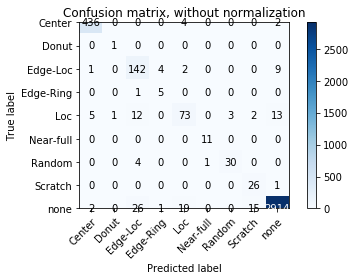

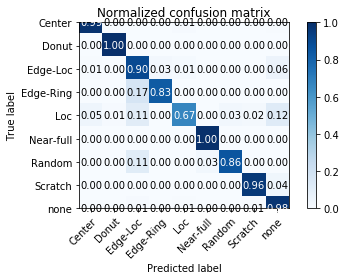

In [263]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(rny_test_decode, rny_pred_decode, classes=faulty_case, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(rny_test_decode, rny_pred_decode, classes=faulty_case, normalize=True, title='Normalized confusion matrix')

plt.show()

# ResNet50 model

In [252]:
Rmodel = ResNet50(input_shape = (27, 27, 3), classes = 9)

In [253]:
Rmodel.compile(optimizer= optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [254]:
Res_hist = Rmodel.fit(dnx_train, dy_train, epochs = 30, validation_data=[nx_test, y_test], batch_size = 600, shuffle=True)

Train on 91818 samples, validate on 3766 samples
Epoch 1/50
91818/91818 [==============================] - 42s 455us/step - loss: 0.5352 - accuracy: 0.8106 - val_loss: 5.1029 - val_accuracy: 0.0072
Epoch 2/50
91818/91818 [==============================] - 32s 349us/step - loss: 0.2437 - accuracy: 0.9106 - val_loss: 5.8501 - val_accuracy: 0.0236
Epoch 3/50
91818/91818 [==============================] - 32s 348us/step - loss: 0.1671 - accuracy: 0.9398 - val_loss: 2.5227 - val_accuracy: 0.3152
Epoch 4/50
91818/91818 [==============================] - 32s 350us/step - loss: 0.1408 - accuracy: 0.9498 - val_loss: 0.1395 - val_accuracy: 0.9599
Epoch 5/50
91818/91818 [==============================] - 32s 350us/step - loss: 0.1066 - accuracy: 0.9621 - val_loss: 0.2061 - val_accuracy: 0.9602
Epoch 6/50
91818/91818 [==============================] - 32s 350us/step - loss: 0.0922 - accuracy: 0.9670 - val_loss: 0.1163 - val_accuracy: 0.9665
Epoch 7/50
91818/91818 [==============================] -

In [255]:
Res_preds = Rmodel.evaluate(nx_test, y_test)
print ("Loss = " + str(Res_preds[0]))
print ("Test Accuracy = " + str(Res_preds[1]))

3766/3766 [==============================] - 3s 869us/step
Loss = 0.1444776780333844
Test Accuracy = 0.9702602028846741


In [256]:
Rmodel.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           (None, 27, 27, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_9 (ZeroPadding2D (None, 29, 29, 3)    0           input_20[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 27, 27, 64)   1792        zero_padding2d_9[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 27, 27, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

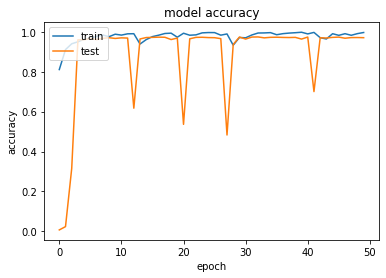

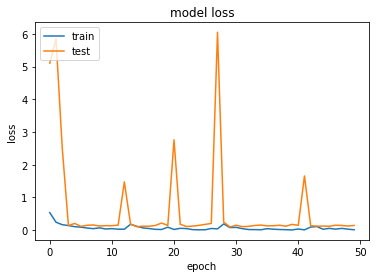

In [257]:
# accuracy plot 
plt.plot(Res_hist.history['accuracy'])
plt.plot(Res_hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(Res_hist.history['loss'])
plt.plot(Res_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [258]:
ry_pred = Rmodel.predict(nx_test)

In [259]:
ry_test_decode = np.ones(len(y_test))
ry_pred_decode = np.ones(len(ry_pred))

for i in range(len(ry_pred)):
    ry_pred_decode[i] = np.argmax(ry_pred[i])
    ry_test_decode[i] = np.argmax(y_test[i])

In [260]:
rmis_index = np.where(ry_pred_decode != ry_test_decode)

In [261]:
print(classification_report(ry_test_decode, ry_pred_decode, target_names=faulty_case))

              precision    recall  f1-score   support

      Center       0.98      0.98      0.98       442
       Donut       1.00      1.00      1.00         1
    Edge-Loc       0.88      0.85      0.87       158
   Edge-Ring       0.83      0.83      0.83         6
         Loc       0.74      0.69      0.71       109
   Near-full       1.00      1.00      1.00        11
      Random       0.94      0.83      0.88        35
     Scratch       0.89      0.59      0.71        27
        none       0.98      0.99      0.99      2977

    accuracy                           0.97      3766
   macro avg       0.92      0.86      0.89      3766
weighted avg       0.97      0.97      0.97      3766



Confusion matrix, without normalization
[[ 435    0    1    0    3    0    0    0    3]
 [   0    1    0    0    0    0    0    0    0]
 [   2    0  135    1    4    0    0    0   16]
 [   0    0    1    5    0    0    0    0    0]
 [   3    0    6    0   75    0    2    1   22]
 [   0    0    0    0    0   11    0    0    0]
 [   0    0    4    0    0    0   29    0    2]
 [   0    0    0    0    2    0    0   16    9]
 [   5    0    6    0   18    0    0    1 2947]]
Normalized confusion matrix
[[9.84162896e-01 0.00000000e+00 2.26244344e-03 0.00000000e+00
  6.78733032e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
  6.78733032e-03]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [1.26582278e-02 0.00000000e+00 8.54430380e-01 6.32911392e-03
  2.53164557e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.01265823e-01]
 [0.00000000e+00 0.00000000e+00 1.66666667e-01 8.33333333e-01
  0.0000000

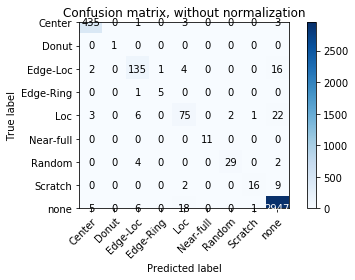

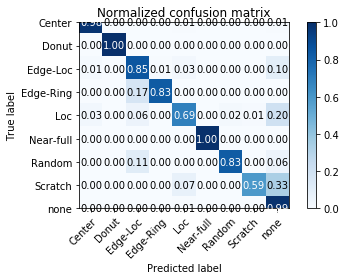

In [262]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(ry_test_decode, ry_pred_decode, classes=faulty_case, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(ry_test_decode, ry_pred_decode, classes=faulty_case, normalize=True, title='Normalized confusion matrix')

plt.show()


## Correcting label by the result of the model classifier (if prob > 0.95)!

## For the original data before data augmentation

## (Not used for the project result but this test was done!)


In [281]:
new_x.shape, new_y.shape

((18829, 27, 27), (18829, 1))

In [282]:
# make string label data to numerical data
for i, l in enumerate(faulty_case):
    new_y[new_y==l] = i
    
# one-hot-encoding
corr_new_y = to_categorical(new_y)

In [283]:
corr_new_x = new_x.reshape((-1, 27, 27, 1))

In [284]:
# One-hot-Encoding faulty categorical variable as channel
corr_x = np.zeros((len(corr_new_x), 27, 27, 3))

for w in range(len(corr_new_x)):
    for i in range(27):
        for j in range(27):
            corr_x[w, i, j, int(corr_new_x[w, i, j])] = 1

In [285]:
corr_x.shape, corr_new_y.shape

((18829, 27, 27, 3), (18829, 9))

In [286]:
# 1st 
# Make a prediction for lable correction 
# by using the classified result of the model(Classifier)

corr_pred = WF_model.predict(corr_x)

In [287]:
cy_train_decode = np.ones(len(corr_new_y))
cy_train_pred_decode = np.ones(len(corr_pred))

for i in range(len(corr_pred)):
    cy_train_pred_decode[i] = np.argmax(corr_pred[i])
    cy_train_decode[i] = np.argmax(corr_new_y[i])

In [288]:
cmis_train_index = np.where(cy_train_pred_decode != cy_train_decode)

In [293]:
cmis_pred_list = np.zeros(len(cmis_train_index[0]))
for i in range (len(cmis_train_index[0])):
    cmis_pred_list[i] = corr_pred[cmis_train_index[0][i]][np.argmax(corr_pred[cmis_train_index[0][i]])]
    
cmis_pred_list.sort()
corr_c = 0
for i in range (len(cmis_train_index[0])):
    print('Prob: {:.2f}'.format(cmis_pred_list[i]))
    if cmis_pred_list[i] >= 0.98:
        corr_c += 1
print('# of lable correct:{}, Percentage:{:.2f}' .format(corr_c, corr_c/len(cmis_train_index[0])))

Prob: 0.37
Prob: 0.40
Prob: 0.40
Prob: 0.42
Prob: 0.45
Prob: 0.49
Prob: 0.49
Prob: 0.49
Prob: 0.50
Prob: 0.50
Prob: 0.51
Prob: 0.51
Prob: 0.51
Prob: 0.53
Prob: 0.53
Prob: 0.53
Prob: 0.54
Prob: 0.54
Prob: 0.54
Prob: 0.54
Prob: 0.55
Prob: 0.55
Prob: 0.55
Prob: 0.56
Prob: 0.56
Prob: 0.57
Prob: 0.57
Prob: 0.57
Prob: 0.58
Prob: 0.59
Prob: 0.59
Prob: 0.59
Prob: 0.59
Prob: 0.60
Prob: 0.60
Prob: 0.61
Prob: 0.62
Prob: 0.62
Prob: 0.62
Prob: 0.62
Prob: 0.63
Prob: 0.63
Prob: 0.63
Prob: 0.63
Prob: 0.64
Prob: 0.65
Prob: 0.65
Prob: 0.66
Prob: 0.66
Prob: 0.66
Prob: 0.66
Prob: 0.68
Prob: 0.68
Prob: 0.68
Prob: 0.69
Prob: 0.69
Prob: 0.70
Prob: 0.70
Prob: 0.70
Prob: 0.72
Prob: 0.72
Prob: 0.72
Prob: 0.72
Prob: 0.73
Prob: 0.73
Prob: 0.73
Prob: 0.73
Prob: 0.73
Prob: 0.73
Prob: 0.73
Prob: 0.74
Prob: 0.74
Prob: 0.75
Prob: 0.76
Prob: 0.76
Prob: 0.76
Prob: 0.77
Prob: 0.77
Prob: 0.78
Prob: 0.79
Prob: 0.79
Prob: 0.79
Prob: 0.80
Prob: 0.80
Prob: 0.81
Prob: 0.82
Prob: 0.82
Prob: 0.82
Prob: 0.84
Prob: 0.84
Prob: 0.85

In [291]:
len(cmis_train_index[0])

160

Confusion matrix, without normalization
[[ 2328     0     2     0    28     0     0     0     6]
 [    0     7     0     0     0     0     0     0     0]
 [    0     0   700     4    17     1     4     0    21]
 [    0     0     1    55     0     0     0     0     0]
 [    5     0     5     0   544     0     3     3    13]
 [    0     0     0     0     0    48     0     0     0]
 [    0     0     1     0     1     1   133     0     1]
 [    0     0     0     0     0     0     0    99     3]
 [    6     0     9     0    19     0     2     4 14755]]
Normalized confusion matrix
[[9.84771574e-01 0.00000000e+00 8.46023689e-04 0.00000000e+00
  1.18443316e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  2.53807107e-03]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 9.37081660e-01 5.35475234e-03
  2.27576975e-02 1.33868809e-03 5.35475234e-03 0.00000000e+00
  2.811244

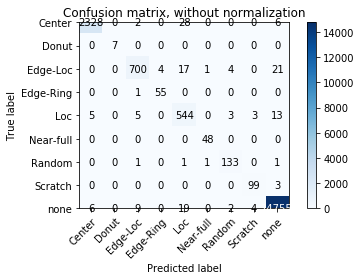

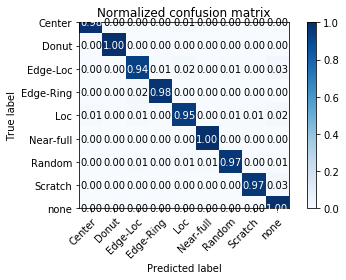

In [292]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(cy_train_decode, cy_train_pred_decode, classes=faulty_case, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(cy_train_decode, cy_train_pred_decode, classes=faulty_case, normalize=True, title='Normalized confusion matrix')

plt.show()

In [294]:
#remove channel
cpx_train = corr_new_x[:,:,:,0]

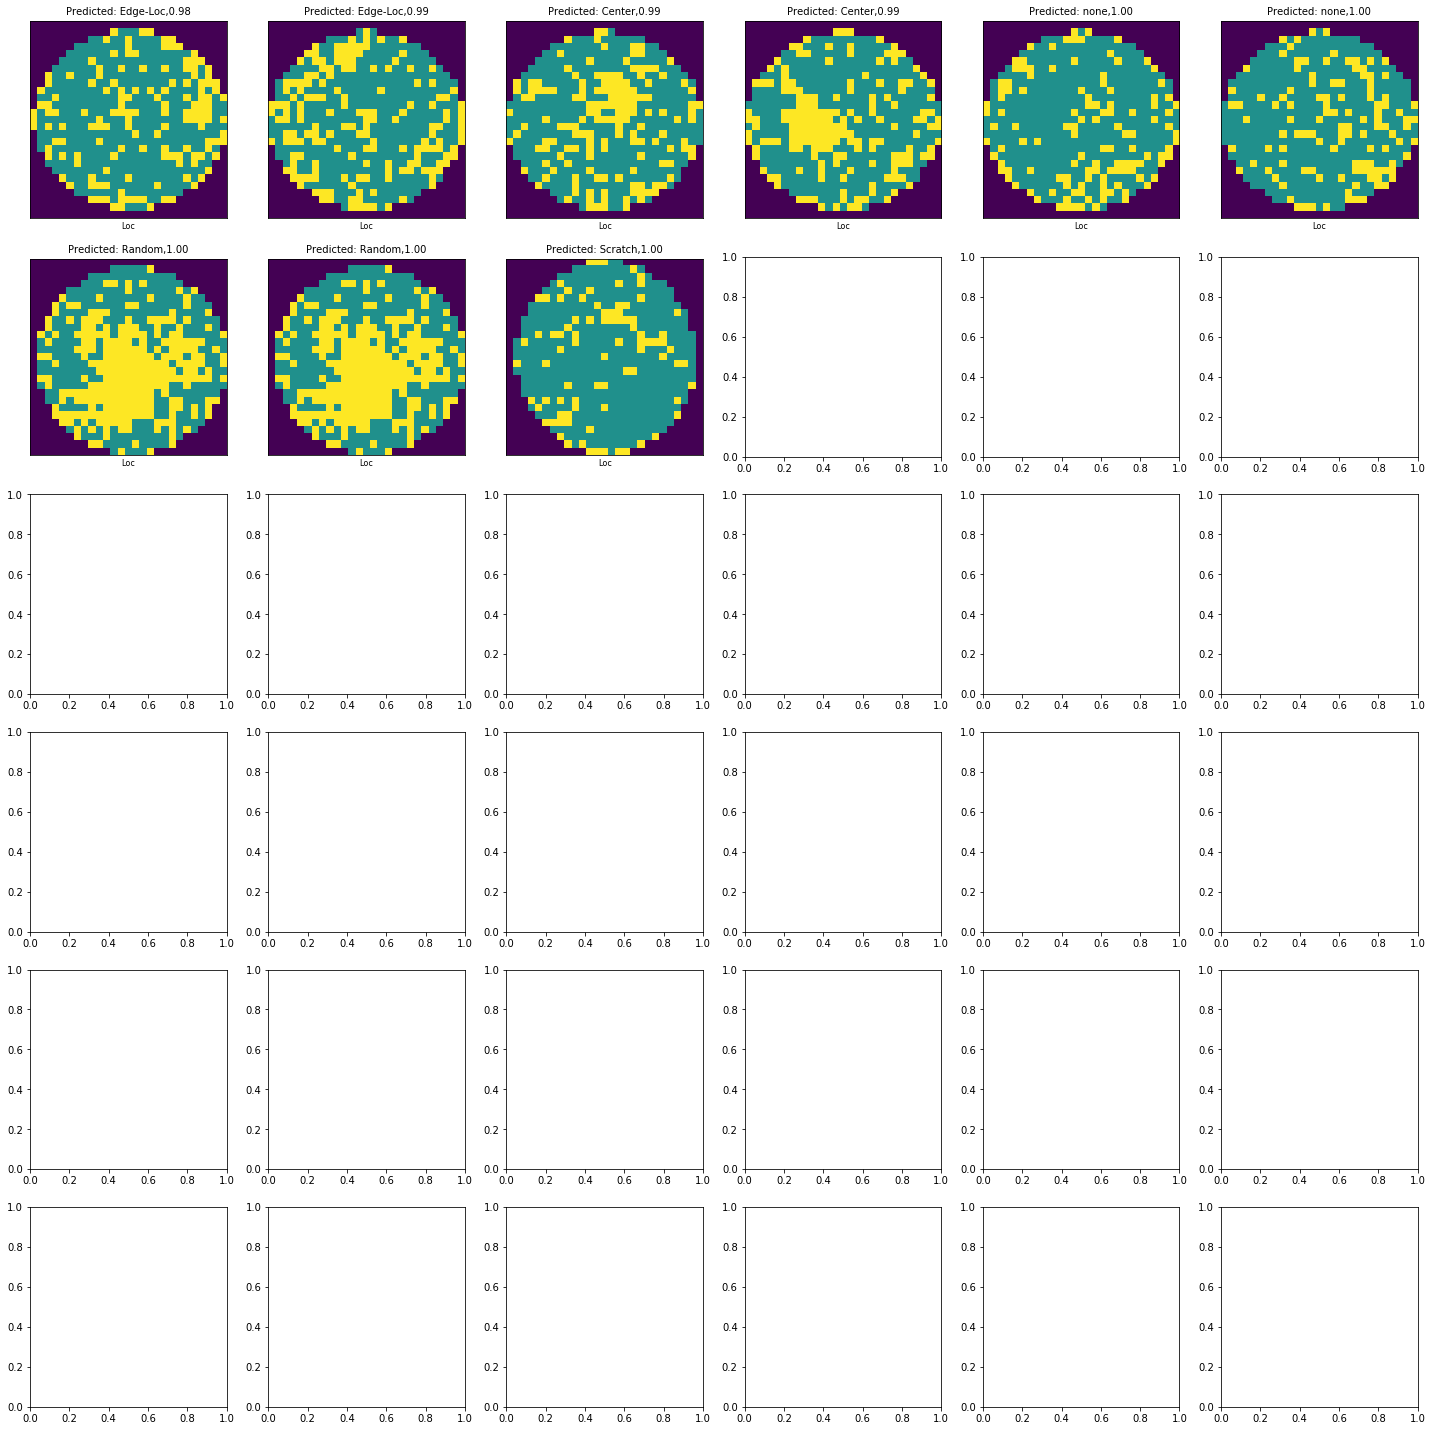

In [296]:
#Draw misclassified image
#Loc (Local)
cnt = 0
fig, ax = plt.subplots(nrows = 6, ncols = 6, figsize=(20, 20))
ax = ax.ravel(order='C')
j=0
for i in range(len(cmis_train_index[0])):
        if (faulty_case[int(cy_train_decode[cmis_train_index[0][i]])] == 'Loc') & (corr_pred[cmis_train_index[0][i]][np.argmax(corr_pred[cmis_train_index[0][i]])] >= 0.98):
            img = cpx_train[cmis_train_index[0][i]]
            ax[j].imshow(img)
            ax[j].set_title('Predicted: {},{:.2f}'.format(faulty_case[int(cy_train_pred_decode[cmis_train_index[0][i]])], corr_pred[cmis_train_index[0][i]][np.argmax(corr_pred[cmis_train_index[0][i]])]), fontsize=10)
            ax[j].set_xlabel(faulty_case[int(cy_train_decode[cmis_train_index[0][i]])], fontsize=8)
            ax[j].set_xticks([])
            ax[j].set_yticks([])
            j += 1
        if j == 36:
            break
plt.tight_layout()
plt.show() 

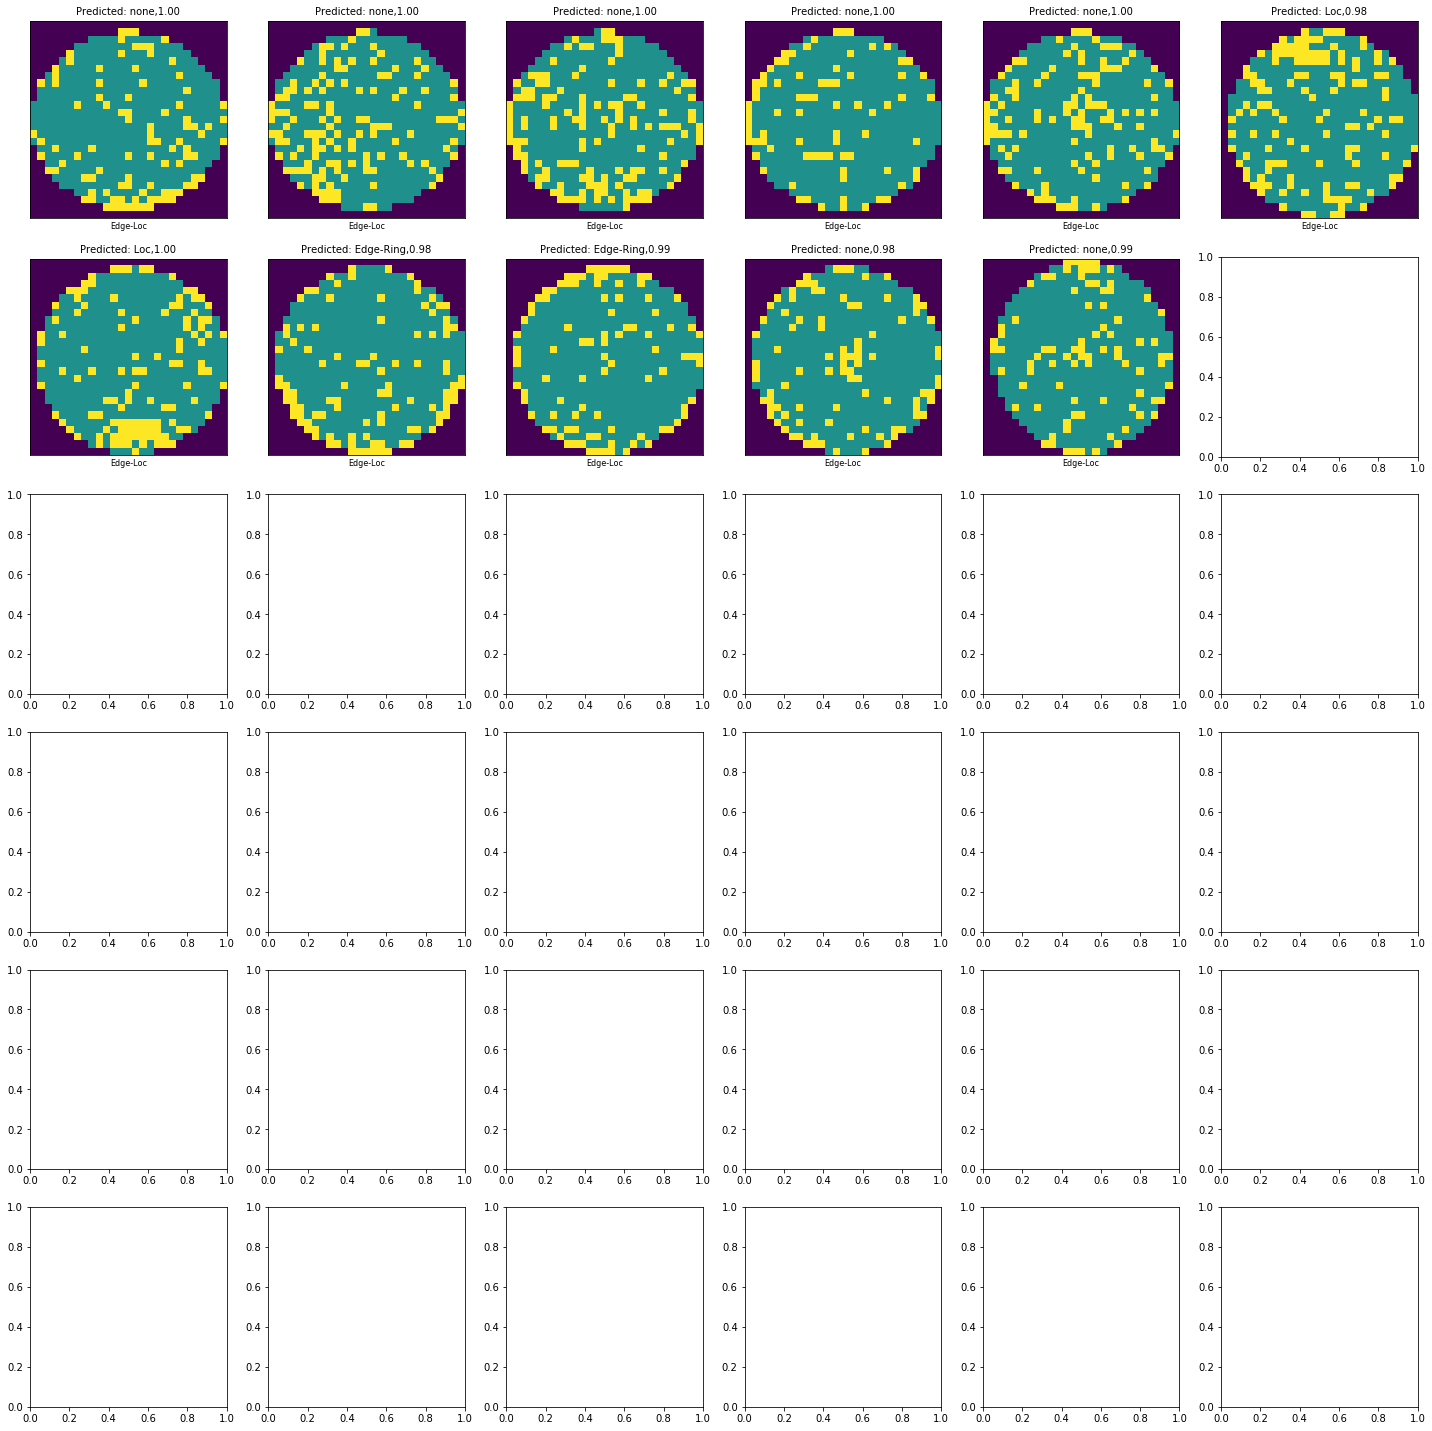

In [297]:
#Draw misclassified image
#Loc (Local)
cnt = 0
fig, ax = plt.subplots(nrows = 6, ncols = 6, figsize=(20, 20))
ax = ax.ravel(order='C')
j=0
for i in range(len(cmis_train_index[0])):
        if (faulty_case[int(cy_train_decode[cmis_train_index[0][i]])] == 'Edge-Loc') & (corr_pred[cmis_train_index[0][i]][np.argmax(corr_pred[cmis_train_index[0][i]])] >= 0.98):
            img = cpx_train[cmis_train_index[0][i]]
            ax[j].imshow(img)
            ax[j].set_title('Predicted: {},{:.2f}'.format(faulty_case[int(cy_train_pred_decode[cmis_train_index[0][i]])], corr_pred[cmis_train_index[0][i]][np.argmax(corr_pred[cmis_train_index[0][i]])]), fontsize=10)
            ax[j].set_xlabel(faulty_case[int(cy_train_decode[cmis_train_index[0][i]])], fontsize=8)
            ax[j].set_xticks([])
            ax[j].set_yticks([])
            j += 1
        if j == 36:
            break
plt.tight_layout()
plt.show() 

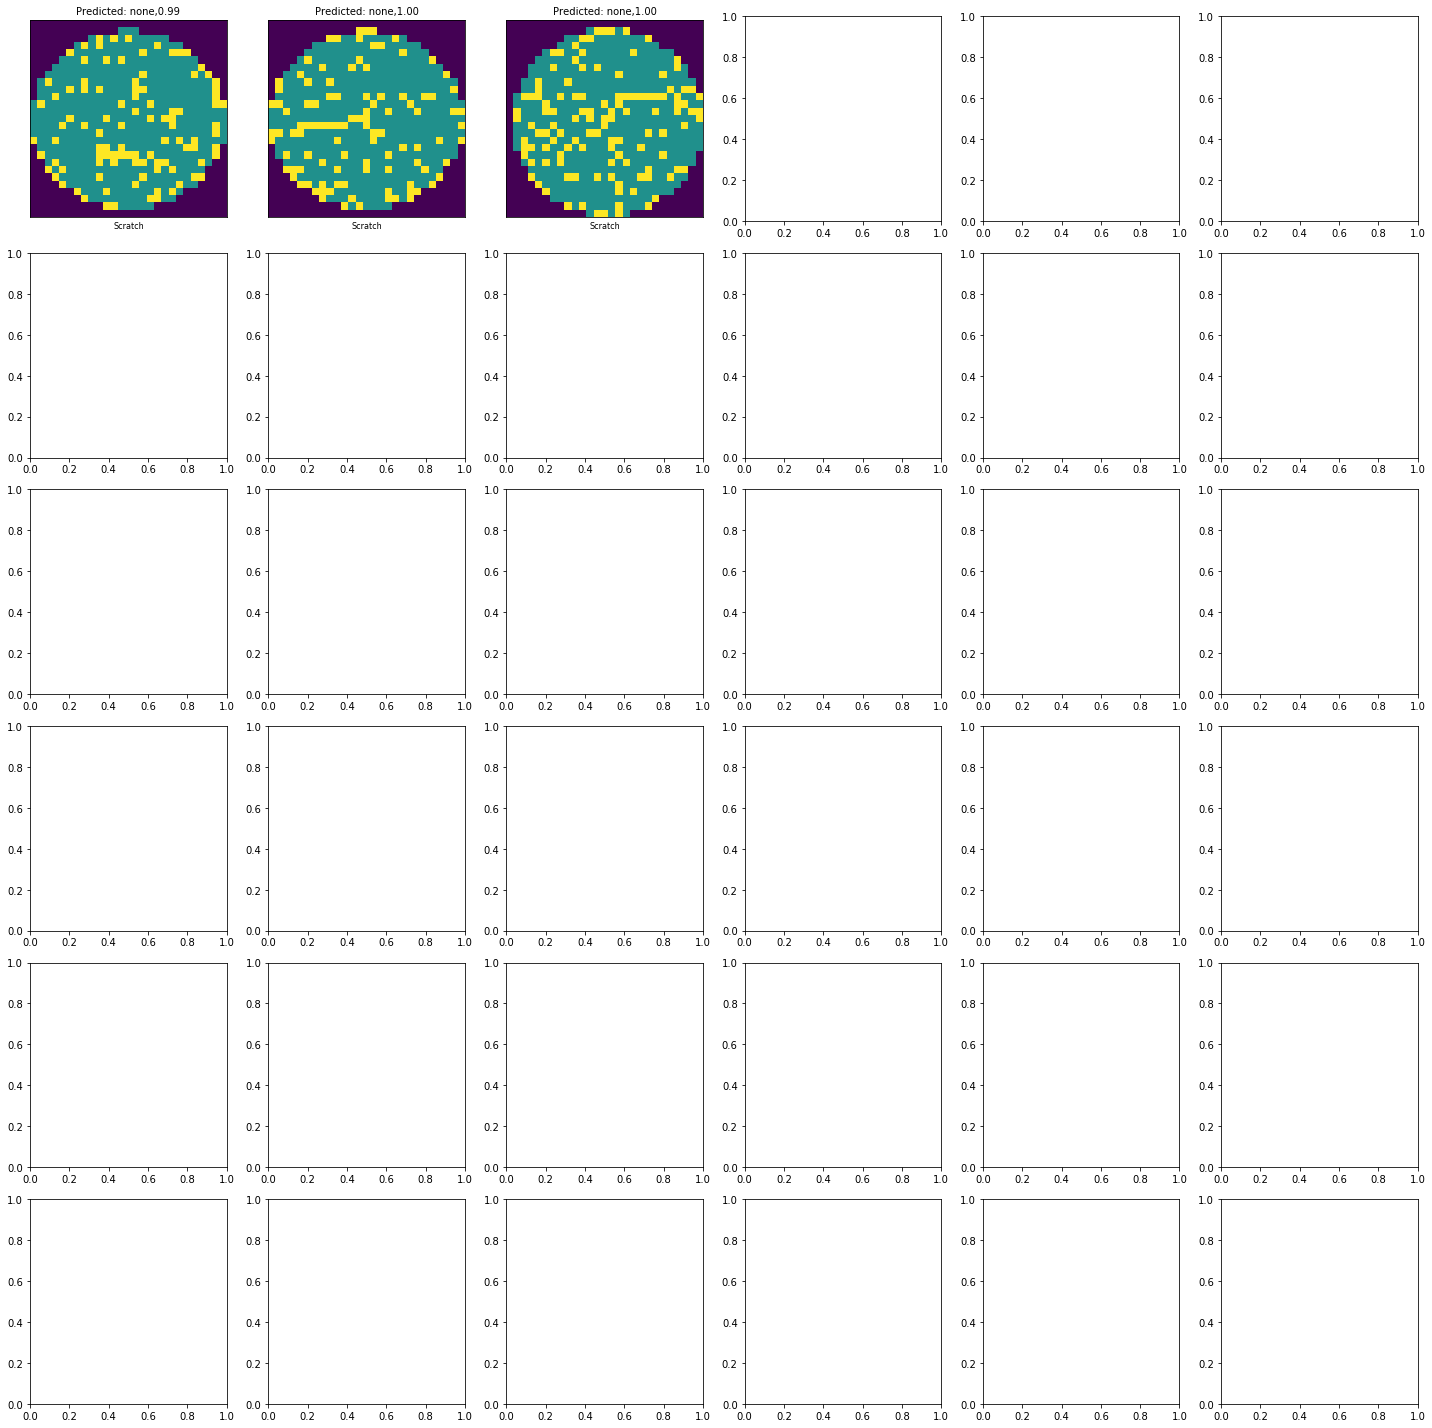

In [298]:
#Draw misclassified image
#Loc (Local)
cnt = 0
fig, ax = plt.subplots(nrows = 6, ncols = 6, figsize=(20, 20))
ax = ax.ravel(order='C')
j=0
for i in range(len(cmis_train_index[0])):
        if faulty_case[int(cy_train_decode[cmis_train_index[0][i]])] == 'Scratch':
            img = cpx_train[cmis_train_index[0][i]]
            ax[j].imshow(img)
            ax[j].set_title('Predicted: {},{:.2f}'.format(faulty_case[int(cy_train_pred_decode[cmis_train_index[0][i]])], corr_pred[cmis_train_index[0][i]][np.argmax(corr_pred[cmis_train_index[0][i]])]), fontsize=10)
            ax[j].set_xlabel(faulty_case[int(cy_train_decode[cmis_train_index[0][i]])], fontsize=8)
            ax[j].set_xticks([])
            ax[j].set_yticks([])
            j += 1
        if j == 36:
            break
plt.tight_layout()
plt.show() 


## updating the label by the prediction result having 95% probability of misclassification


In [272]:
updated_y = np.ones(len(corr_new_y))

for i in range(len(corr_new_y)):
    cy_train_pred_decode[i] = np.argmax(corr_pred[i])
    cy_train_decode[i] = np.argmax(corr_new_y[i])
    if (cy_train_pred_decode[i] != cy_train_decode[i]) & (corr_pred[i][np.argmax(corr_pred[i])] >= 0.95) & (np.argmax(corr_new_y[i]) != 7):
        updated_y[i] = np.argmax(corr_pred[i])
    else:
        updated_y[i] = np.argmax(corr_new_y[i])

In [273]:
upd_y = updated_y.reshape((len(corr_new_y),1))

In [274]:
upd_y.shape

(18829, 1)

In [275]:
cmis_train_index[0][0]

8

In [276]:
#original label
corr_new_y[cmis_train_index[0][0]]

array([0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [277]:
upd_y[cmis_train_index[0][0]][0]

2.0

In [278]:
corr_pred[cmis_train_index[0][0]][np.argmax(corr_pred[cmis_train_index[0][0]])] 

0.47365355

In [279]:
corr_pred[cmis_train_index[0][0]]

array([7.17e-04, 5.97e-07, 4.31e-01, 2.26e-05, 4.74e-01, 1.88e-07,
       5.13e-07, 9.49e-02, 2.07e-04], dtype=float32)

# Model Training with corrected label & Predict

In [280]:
new_x.shape, upd_y.shape

((18829, 27, 27), (18829, 1))

In [281]:
#Before Data augmentation: Split the data with 8:2 ratio
x_train_updated, x_test_updated, y_train_updated, y_test_updated = train_test_split(new_x, upd_y, test_size=0.2, random_state=799)

In [282]:
print('Train x : {}, y : {}'.format(x_train_updated.shape, y_train_updated.shape))
print('Test x: {}, y : {}'.format(x_test_updated.shape, y_test_updated.shape))

Train x : (15063, 27, 27), y : (15063, 1)
Test x: (3766, 27, 27), y : (3766, 1)


In [283]:
#new training dataset
for i, f in enumerate(faulty_case) :
    print('{} : {}'.format(f, len(y_train_updated[y_train_updated==i])))

Center : 1881
Donut : 6
Edge-Loc : 583
Edge-Ring : 50
Loc : 455
Near-full : 43
Random : 110
Scratch : 84
none : 11851


In [284]:
#new test dataset
for i, f in enumerate(faulty_case) :
    print('{} : {}'.format(f, len(y_test_updated[y_test_updated==i])))

Center : 482
Donut : 1
Edge-Loc : 154
Edge-Ring : 14
Loc : 114
Near-full : 7
Random : 29
Scratch : 28
none : 2937


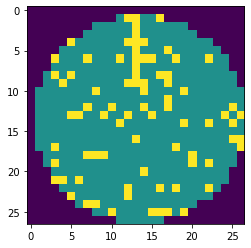

In [285]:
plt.imshow(x_train_updated[np.where(y_train_updated==7)[0][31]])

In [286]:
#Training Data augmentation by rotating
rot_X = np.ones((1, 27, 27))
r_x = np.ones((1, 27, 27))
y_label = list()

for i, f in enumerate(faulty_case):
    if(len(y_train_updated[y_train_updated==i]) < 10000):
        for j in range(10000 - len(y_train_updated[y_train_updated==i])):
            n = np.random.randint(len(y_train_updated[y_train_updated==i]))
            r_x = ndimage.rotate(x_train_updated[np.where(y_train_updated==i)[0][n]], np.random.randint(360), axes=(0,1), mode='constant', order = 0, reshape=False)
            rot_X = np.concatenate((rot_X, r_x.reshape(1,27,27)))
            y_label.append(i)

In [287]:
n_rx = rot_X[1:]
n_ry = np.array(y_label).reshape((-1,1))

In [288]:
da_x_train = np.concatenate((x_train_updated, n_rx[0:]))
da_y_train = np.concatenate((y_train_updated, n_ry))

In [290]:
#After training dataset augmented 
print('After training dataset augmented new_x shape : {}, new_y shape : {}'.format(da_x_train.shape, da_y_train.shape))

After training dataset augmented new_x shape : (91851, 27, 27), new_y shape : (91851, 1)


In [291]:
#augmented training dataset
for i, f in enumerate(faulty_case) :
    print('{} : {}'.format(f, len(da_y_train[da_y_train==i])))

Center : 10000
Donut : 10000
Edge-Loc : 10000
Edge-Ring : 10000
Loc : 10000
Near-full : 10000
Random : 10000
Scratch : 10000
none : 11851


In [292]:
#x_train: add channel
da_x_train = da_x_train.reshape((-1, 27, 27, 1))

In [293]:
# One-hot-Encoding faulty categorical variable as channel
cnx_train = np.zeros((len(da_x_train), 27, 27, 3))

for w in range(len(da_x_train)):
    for i in range(27):
        for j in range(27):
            cnx_train[w, i, j, int(da_x_train[w, i, j])] = 1

In [294]:
# one-hot-encoding
da_y_train = to_categorical(da_y_train)

In [295]:
# one-hot-encoding
y_test_updated = to_categorical(y_test_updated)

In [296]:
x_test_updated = x_test_updated.reshape((-1, 27, 27, 1))

In [297]:
# One-hot-Encoding faulty categorical variable as channel
cnx_test = np.zeros((len(x_test_updated), 27, 27, 3))

for w in range(len(x_test_updated)):
    for i in range(27):
        for j in range(27):
            cnx_test[w, i, j, int(x_test_updated[w, i, j])] = 1

In [298]:
cnx_train.shape, da_y_train.shape, cnx_test.shape, y_test_updated.shape

((91851, 27, 27, 3), (91851, 9), (3766, 27, 27, 3), (3766, 9))

In [299]:
n_epoch = 100
n_batch_size = 900

In [1]:
NW_model = create_model()

NameError: name 'create_model' is not defined

In [ ]:
NW_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [569]:
NW_model.summary()

Model: "model_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        (None, 27, 27, 3)         0         
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 27, 27, 16)        448       
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 27, 27, 64)        9280      
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 13, 13, 128)       73856     
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 13, 13, 256)       295168    
_________________________________________________________________
global_average_pooling2d_20  (None, 256)               0  

In [531]:
nlast_conv_layer = NW_model.get_layer('conv2d_71')

In [ ]:
New_Hist = NW_model.fit(cnx_train, da_y_train, epochs=n_epoch, validation_data=[cnx_test, y_test_updated], batch_size=n_batch_size, shuffle=True)

Train on 91851 samples, validate on 3766 samples
Epoch 1/100
91851/91851 [==============================] - 11s 116us/step - loss: 1.9908 - accuracy: 0.3916 - val_loss: 1.0281 - val_accuracy: 0.8128
Epoch 2/100
91851/91851 [==============================] - 9s 96us/step - loss: 1.4024 - accuracy: 0.5047 - val_loss: 0.7228 - val_accuracy: 0.8314
Epoch 3/100
91851/91851 [==============================] - 9s 96us/step - loss: 1.2044 - accuracy: 0.5776 - val_loss: 0.9641 - val_accuracy: 0.7600
Epoch 4/100
91851/91851 [==============================] - 9s 96us/step - loss: 1.0341 - accuracy: 0.6508 - val_loss: 0.5669 - val_accuracy: 0.8640
Epoch 5/100
91851/91851 [==============================] - 9s 97us/step - loss: 0.8604 - accuracy: 0.7172 - val_loss: 0.4513 - val_accuracy: 0.8946
Epoch 6/100
91851/91851 [==============================] - 9s 100us/step - loss: 0.7466 - accuracy: 0.7593 - val_loss: 0.4328 - val_accuracy: 0.8903
Epoch 7/100
91851/91851 [==============================] - 9

In [ ]:
### START CODE HERE ### (1 line)
pred = NW_model.evaluate(x = cnx_test, y = y_test_updated)
### END CODE HERE ###
print()
print ("Loss = " + str(pred[0]))
print ("Test Accuracy = " + str(pred[1]))

In [ ]:
# accuracy plot 
plt.plot(New_Hist.history['accuracy'])
plt.plot(New_Hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(New_Hist.history['loss'])
plt.plot(New_Hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
nw_pred = NW_model.predict(cnx_test)

In [ ]:
ny_test_decode = np.ones(len(y_test_updated))
ny_test_pred_decode = np.ones(len(nw_pred))

for i in range(len(nw_pred)):
    ny_test_pred_decode[i] = np.argmax(nw_pred[i])
    ny_test_decode[i] = np.argmax(y_test_updated[i])

In [ ]:
umis_index = np.where(ny_test_pred_decode != ny_test_decode)

In [ ]:
len(umis_index[0])

In [ ]:
print(classification_report(ny_test_decode, ny_test_pred_decode, target_names=faulty_case))

In [ ]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(ny_test_decode, ny_test_pred_decode, classes=faulty_case, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(ny_test_decode, ny_test_pred_decode, classes=faulty_case, normalize=True, title='Normalized confusion matrix')

plt.show()

In [314]:
#remove channel
ux_test = x_test_updated[:,:,:,0]

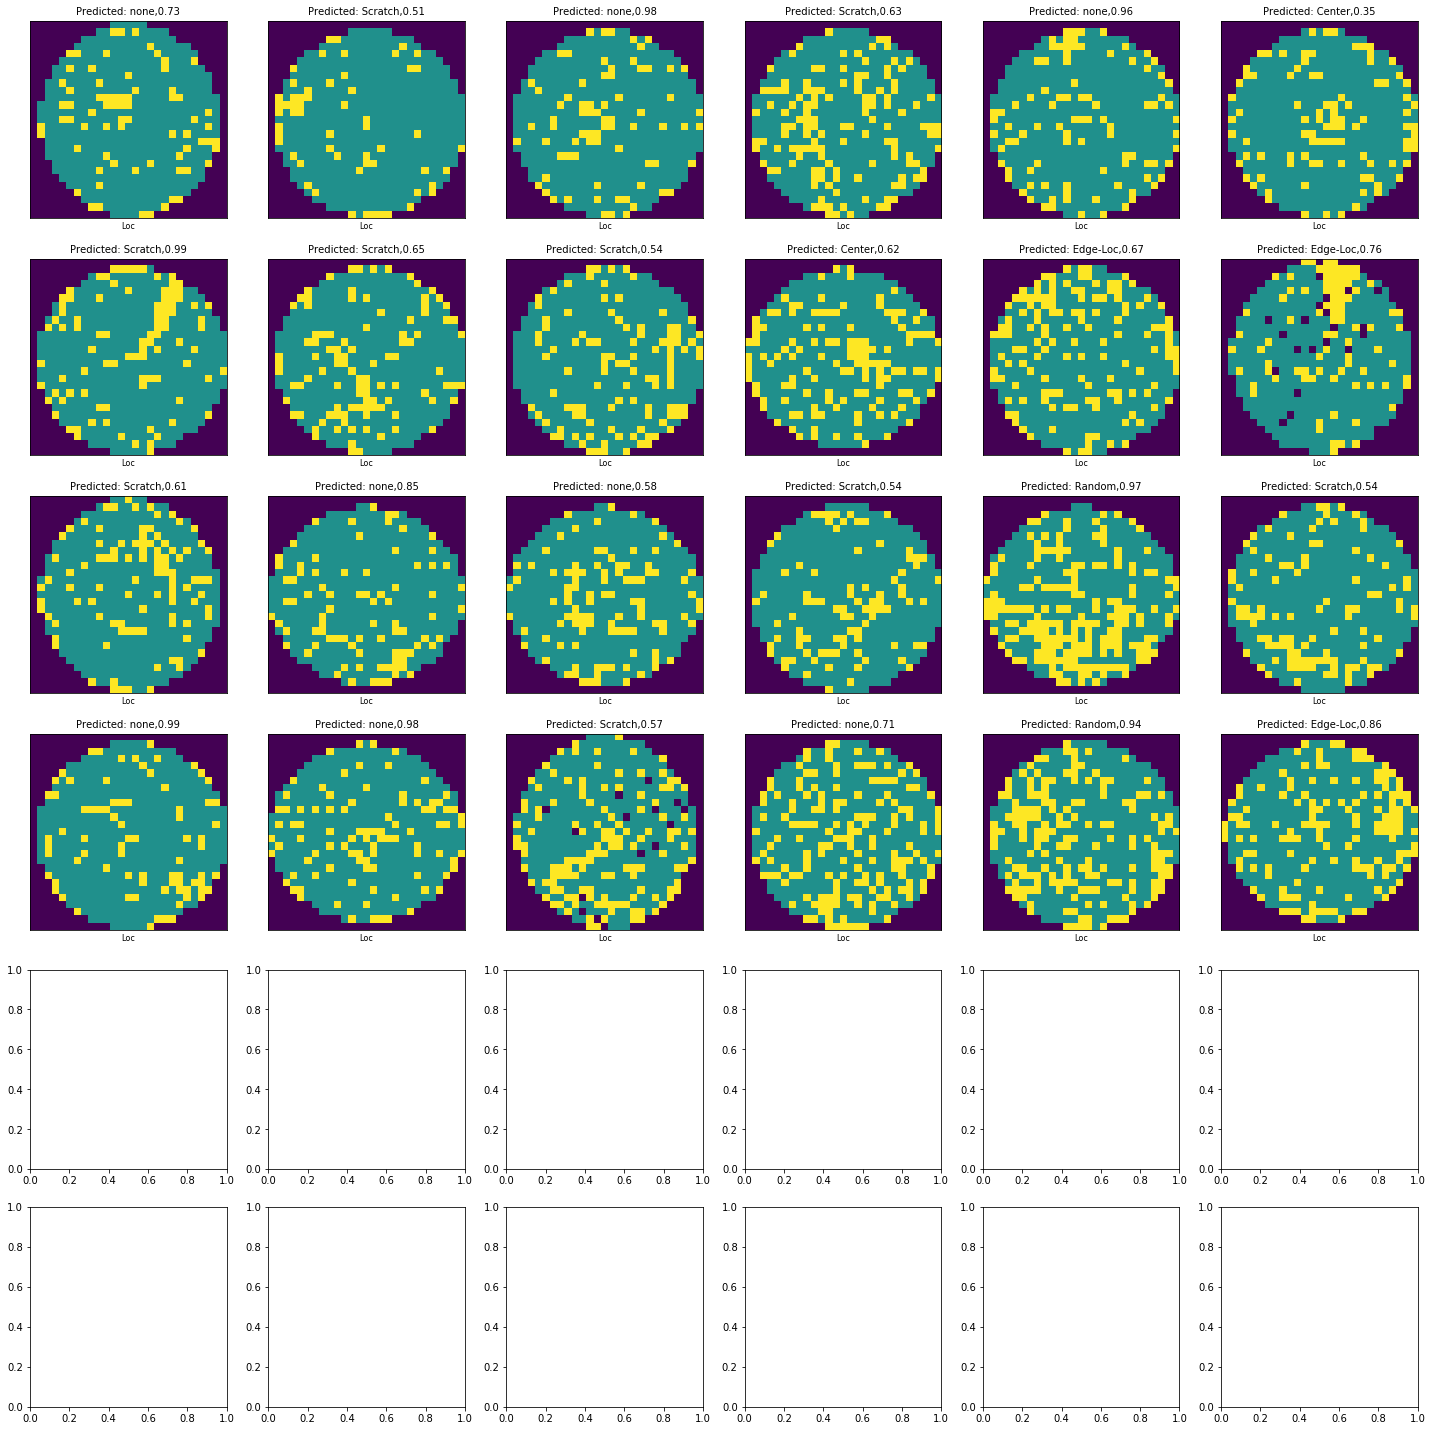

In [315]:
#Draw misclassified image
#Loc (Local)
cnt = 0
fig, ax = plt.subplots(nrows = 6, ncols = 6, figsize=(20, 20))
ax = ax.ravel(order='C')
j=0
for i in range(len(umis_index[0])):
        if faulty_case[int(ny_test_decode[umis_index[0][i]])] == 'Loc':
            img = ux_test[umis_index[0][i]]
            ax[j].imshow(img)
            ax[j].set_title('Predicted: {},{:.2f}'.format(faulty_case[int(ny_test_pred_decode[umis_index[0][i]])], nw_pred[umis_index[0][i]][np.argmax(nw_pred[umis_index[0][i]])]), fontsize=10)
            ax[j].set_xlabel(faulty_case[int(ny_test_decode[umis_index[0][i]])], fontsize=8)
            ax[j].set_xticks([])
            ax[j].set_yticks([])
            j += 1
        if j == 36:
            break
plt.tight_layout()
plt.show() 

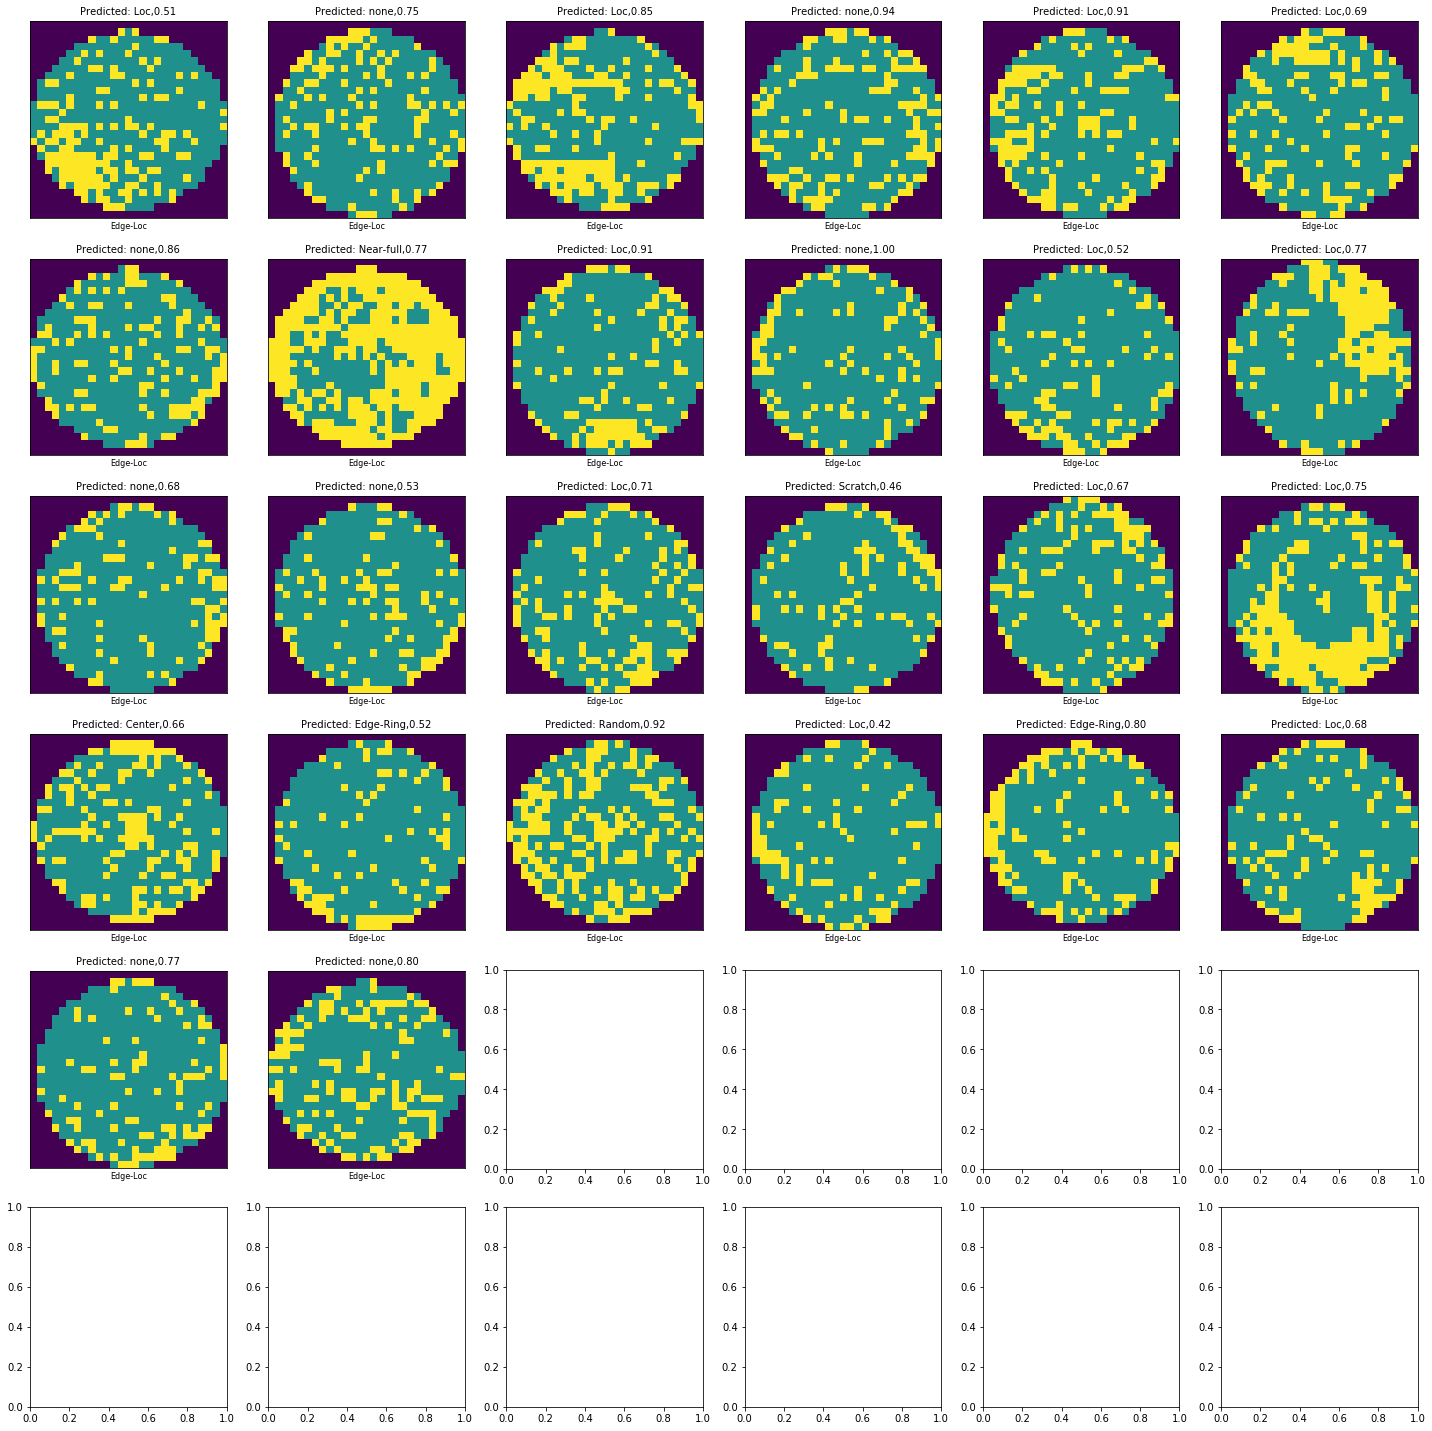

In [316]:
#Draw misclassified image
#Loc (Local)
cnt = 0
fig, ax = plt.subplots(nrows = 6, ncols = 6, figsize=(20, 20))
ax = ax.ravel(order='C')
j=0
for i in range(len(umis_index[0])):
        if faulty_case[int(ny_test_decode[umis_index[0][i]])] == 'Edge-Loc':
            img = ux_test[umis_index[0][i]]
            ax[j].imshow(img)
            ax[j].set_title('Predicted: {},{:.2f}'.format(faulty_case[int(ny_test_pred_decode[umis_index[0][i]])], nw_pred[umis_index[0][i]][np.argmax(nw_pred[umis_index[0][i]])]), fontsize=10)
            ax[j].set_xlabel(faulty_case[int(ny_test_decode[umis_index[0][i]])], fontsize=8)
            ax[j].set_xticks([])
            ax[j].set_yticks([])
            j += 1
        if j == 36:
            break
plt.tight_layout()
plt.show() 

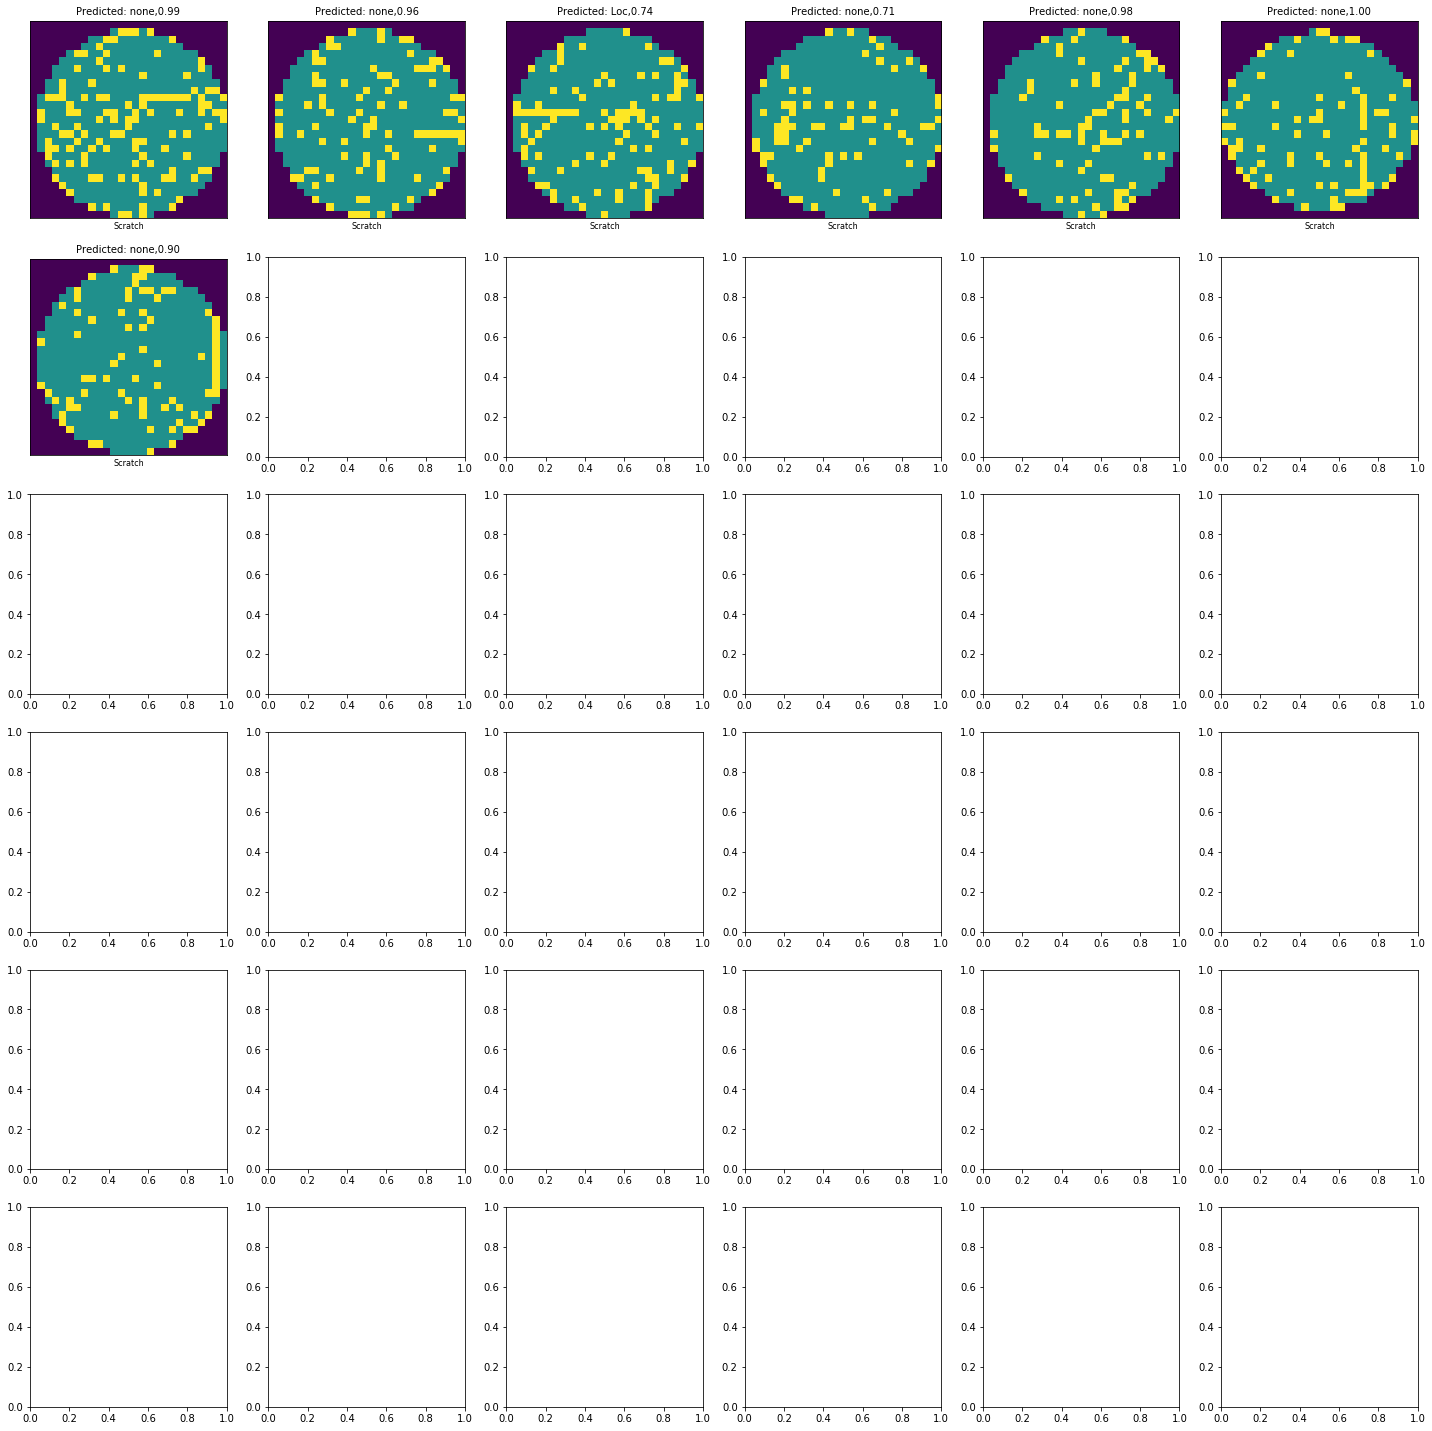

In [317]:
#Draw misclassified image
#Loc (Local)
cnt = 0
fig, ax = plt.subplots(nrows = 6, ncols = 6, figsize=(20, 20))
ax = ax.ravel(order='C')
j=0
for i in range(len(umis_index[0])):
        if faulty_case[int(ny_test_decode[umis_index[0][i]])] == 'Scratch':
            img = ux_test[umis_index[0][i]]
            ax[j].imshow(img)
            ax[j].set_title('Predicted: {},{:.2f}'.format(faulty_case[int(ny_test_pred_decode[umis_index[0][i]])], nw_pred[umis_index[0][i]][np.argmax(nw_pred[umis_index[0][i]])]), fontsize=10)
            ax[j].set_xlabel(faulty_case[int(ny_test_decode[umis_index[0][i]])], fontsize=8)
            ax[j].set_xticks([])
            ax[j].set_yticks([])
            j += 1
        if j == 36:
            break
plt.tight_layout()
plt.show() 

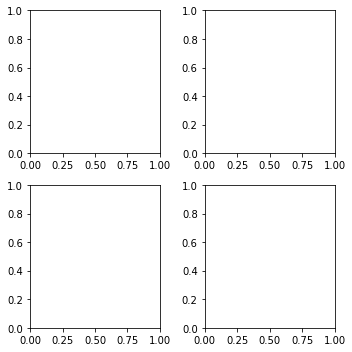

In [318]:
#Draw misclassified image
#Loc (Local)
cnt = 0
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize=(5, 5))
ax = ax.ravel(order='C')
j=0
for i in range(len(umis_index[0])):
        if faulty_case[int(ny_test_decode[umis_index[0][i]])] == 'Donut':
            img = ux_test[umis_index[0][i]]
            ax[j].imshow(img)
            ax[j].set_title('Predicted: {},{:.2f}'.format(faulty_case[int(ny_test_pred_decode[umis_index[0][i]])], nw_pred[umis_index[0][i]][np.argmax(nw_pred[umis_index[0][i]])]), fontsize=10)
            ax[j].set_xlabel(faulty_case[int(ny_test_decode[umis_index[0][i]])], fontsize=8)
            ax[j].set_xticks([])
            ax[j].set_yticks([])
            j += 1
        if j == 4:
            break
plt.tight_layout()
plt.show() 

In [319]:
#Class Activation Map (CAM)

In [320]:
nclass_weights = NW_model.layers[-1].get_weights()[0]

In [321]:
nclass_weights.shape

(256, 9)

In [322]:
nget_output = K.function([NW_model.input], [nlast_conv_layer.output, NW_model.layers[-1].output])

In [323]:
[nf_conv_outputs, npredictions] = nget_output([cnx_test])

In [324]:
nf_conv_outputs.shape, npredictions.shape

((3766, 13, 13, 256), (3766, 9))

In [325]:
nconv_outputs = nf_conv_outputs[0,:,:,:]

In [326]:
nconv_outputs.shape

(13, 13, 256)

In [327]:
#Create the class activation map.
ncam = np.zeros(dtype = np.float32, shape = nconv_outputs.shape[0:2])

In [328]:
ncam.shape

(13, 13)

In [329]:
t_class = 1

In [330]:
for i, w in enumerate(nclass_weights[:, t_class]):
    ncam += w * nconv_outputs[:,:,i]

In [ ]:
plt.matshow(ncam)

In [332]:
ncam /= np.max(ncam)
ncam = cv2.resize(ncam, (27,27))
nheatmap = cv2.applyColorMap(np.uint8(255 * ncam), cv2.COLORMAP_JET)
nheatmap[np.where(ncam < 0)] = 0

In [ ]:
img = nheatmap * 0.5 + nx_test[1]
plt.imshow(nheatmap)

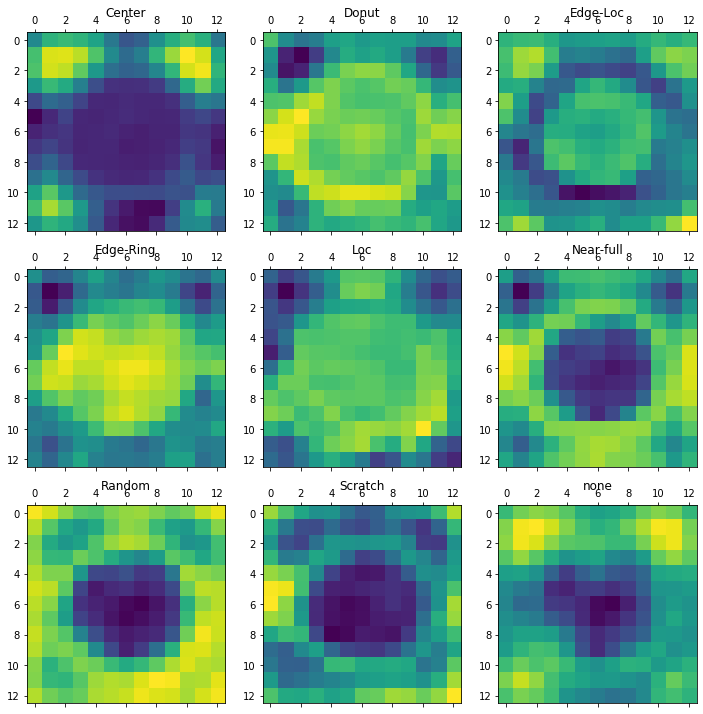

In [334]:
fig, ax = plt.subplots(nrows = 3, ncols = 3, figsize=(10, 10))
ni_cam = np.zeros((9,13,13))
ax = ax.ravel(order='C')
for i in range(9):
    for k, w in enumerate(nclass_weights[:, i]):
        ni_cam[i] += w * nconv_outputs[:, :, k]
    ax[i].matshow(ni_cam[i])
    ax[i].set_title(faulty_case[i])
    k=0
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(nrows = 3, ncols = 3, figsize=(10, 10))
nheatmapi = np.zeros((9,13,13,3))
ax = ax.ravel(order='C')
for i in range(9):
    ni_cam[i] /= np.max(ni_cam[i])
    #ni_cam[i] = cv2.resize(ni_cam[i], (27,27))
    nheatmapi[i] = cv2.applyColorMap(np.uint8(255 * ni_cam[i]), cv2.COLORMAP_JET)
    nheatmapi[i][np.where(ni_cam[i] < 0.2)] = 0
    ax[i].imshow(nheatmapi[i])
    ax[i].set_title(faulty_case[i])
    k=0
plt.tight_layout()
plt.show()

In [336]:
# Gradient Class Activation Map (Grad-CAM)

In [337]:
noutput = NW_model.output

In [338]:
ngrads = K.gradients(noutput, nlast_conv_layer.output)[0]

In [339]:
npooled_grades = K.mean(ngrads, axis=(0,1,2))

In [340]:
niterate = K.function([NW_model.input], [npooled_grades, nlast_conv_layer.output])

In [341]:
npooled_grads_value, nconv_layer_output_value = niterate([cnx_test])

In [342]:
for i in range(256):
    nconv_layer_output_value[0, :, :, i] *= npooled_grads_value[i]

In [343]:
ntest_num = 1

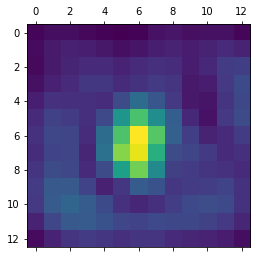

In [344]:
heatmap = np.mean(conv_layer_output_value[ntest_num], axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

Text(0.5, 1.0, 'Center')

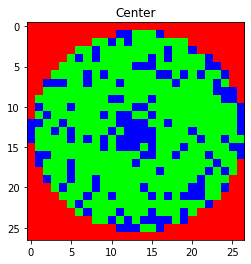

In [345]:
plt.imshow(cnx_test[ntest_num])
b = faulty_case[int(ny_test_decode[ntest_num])]
plt.title(b)
#1:Center, 2:None

In [ ]:
#new training dataset
cnt = 0
for i in range(9):
    for j in range(len(ny_test_decode)):
        if ny_test_decode[j] == i:
            nheatmap = np.mean(nconv_layer_output_value[j], axis=-1)
            nheatmap = np.maximum(nheatmap, 0)
            nheatmap /= np.max(nheatmap)
            plt.matshow(nheatmap)
            plt.title('Lable:{},Predict:{},PR:{:.2f}'.format(faulty_case[int(ny_test_decode[j])], faulty_case[int(ny_pred_decode[j])], np.max(nw_pred[j]) ))
            plt.show()
            cnt +=1
            if cnt > 10:
                break